# Improved Code with different cells

# Basic Mental Health Chatbot with Transformer (From Scratch) - EmpatheticDialogues Dataset

**Improvements:**
*   Uses Hugging Face `tokenizers` (WordPiece) for better tokenization.
*   Trains on the full dataset by default.
*   Includes a validation loop and early stopping based on validation loss.
*   Saves the best model based on validation performance.
*   Increased default epochs (relies on early stopping).
*   Sampling strategies (Top-k, Top-p) for inference.

In [1]:
!pip install datasets tokenizers scikit-learn pandas -q

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau 

from collections import Counter, defaultdict
import math
import random
import re
import os
import time
import json 

from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split 

from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing 

print(f"PyTorch Version: {torch.__version__}")
try:
    import datasets
    import tokenizers
    import sklearn
    import pandas
    print("Required libraries loaded.")
except ImportError as e:
    print(f"Error importing libraries: {e}. Please ensure installs were successful.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires nvidia-curand-cu12==10.3.5.147; platform_system == "Linux" and platform_machin

In [2]:
DATASET_SUBSET_SIZE = None 
MAX_LEN = 60            
VOCAB_SIZE = 20000      
TOKENIZER_FILE = "wp_tokenizer.json" 

BATCH_SIZE = 32          
LEARNING_RATE = 0.0005
N_EPOCHS = 50        
CLIP = 1.0
PATIENCE = 10             

D_MODEL = 256
N_HEADS = 8
ENC_LAYERS = 3
DEC_LAYERS = 3
PF_DIM = 512
DROPOUT = 0.3

SEED = 1234
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED) 


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PAD_TOKEN = "<PAD>"
SOS_TOKEN = "<SOS>"
EOS_TOKEN = "<EOS>"
UNK_TOKEN = "<UNK>"
SPECIAL_TOKENS = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]

Using device: cuda


## 1. Load EmpatheticDialogues Dataset

In [3]:
print("Loading EmpatheticDialogues dataset...")
try:
    empathetic_dialogues = load_dataset("empathetic_dialogues", trust_remote_code=True)
    print(empathetic_dialogues)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise e

Loading EmpatheticDialogues dataset...


README.md:   0%|          | 0.00/7.15k [00:00<?, ?B/s]

empathetic_dialogues.py:   0%|          | 0.00/4.51k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/76673 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12030 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10943 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags'],
        num_rows: 76673
    })
    validation: Dataset({
        features: ['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags'],
        num_rows: 12030
    })
    test: Dataset({
        features: ['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags'],
        num_rows: 10943
    })
})
Dataset loaded successfully.


## 2. Extract Conversation Pairs

In [4]:
def extract_pairs_corrected(split_name, dataset, subset_size=None):
    """Extracts adjacent utterance pairs from a given split of the dataset."""
    inputs = []
    targets = []
    data_split = dataset[split_name]
    print(f"Processing {split_name} split...")
    try:
        df = data_split.to_pandas()
        print(f"Converted {split_name} split to Pandas DataFrame with {len(df)} rows.")

        all_conv_ids = df['conv_id'].unique()
        if subset_size and subset_size < len(all_conv_ids):
            print(f"Selecting a subset of {subset_size} conversation IDs for {split_name} split.")
            selected_conv_ids = random.sample(list(all_conv_ids), subset_size)
            df = df[df['conv_id'].isin(selected_conv_ids)]
            print(f"Subset DataFrame has {len(df)} rows after filtering by conv_id.")

        grouped = df.sort_values('utterance_idx').groupby('conv_id')
        print(f"Grouped into {len(grouped)} conversations.")

        processed_convs = 0
        skipped_short_convs = 0
        for conv_id, group in grouped:
            utterances = group['utterance'].tolist()
            utterances = [u.strip() for u in utterances if u.strip()] 

            if len(utterances) >= 2:
                for i in range(len(utterances) - 1):
                    inputs.append(utterances[i])
                    targets.append(utterances[i+1])
            else:
                skipped_short_convs += 1

            processed_convs += 1
            if processed_convs % 10000 == 0:
                 print(f"  Processed {processed_convs}/{len(grouped)} conversations...")

        print(f"Finished processing {split_name}.")
        print(f"  Found {len(inputs)} input/target pairs.")
        if skipped_short_convs > 0:
            print(f"  Skipped {skipped_short_convs} conversations with less than 2 utterances.")
        return inputs, targets

    except ImportError:
        print("Error: Pandas is required for data extraction. Please install it.")
        raise
    except KeyError as e:
        print(f"Error: Missing expected column in dataset: {e}. Check dataset structure.")
        raise

In [5]:
print("Extracting Training pairs...")
train_inputs, train_targets = extract_pairs_corrected('train', empathetic_dialogues, subset_size=DATASET_SUBSET_SIZE)

print("\nExtracting Validation pairs...")
val_inputs, val_targets = extract_pairs_corrected('validation', empathetic_dialogues, subset_size=None) # Use full validation set

Extracting Training pairs...
Processing train split...
Converted train split to Pandas DataFrame with 76673 rows.
Grouped into 17844 conversations.
  Processed 10000/17844 conversations...
Finished processing train.
  Found 58829 input/target pairs.
  Skipped 64 conversations with less than 2 utterances.

Extracting Validation pairs...
Processing validation split...
Converted validation split to Pandas DataFrame with 12030 rows.
Grouped into 2763 conversations.
Finished processing validation.
  Found 9267 input/target pairs.
  Skipped 5 conversations with less than 2 utterances.


## 3. Tokenizer Training / Loading
Using Hugging Face `tokenizers` library with WordPiece.

In [6]:
def get_training_corpus(inputs_list, targets_list):
    """Generator function to yield batches of text data for tokenizer training"""
    batch_size = 1000
    for i in range(0, len(inputs_list), batch_size):
        yield inputs_list[i : i + batch_size] + targets_list[i : i + batch_size]

In [7]:
if not os.path.exists(TOKENIZER_FILE):
    print(f"Training WordPiece tokenizer (target vocab_size={VOCAB_SIZE})...")
    tokenizer = Tokenizer(WordPiece(unk_token=UNK_TOKEN))

    tokenizer.pre_tokenizer = Whitespace()

    trainer = WordPieceTrainer(
        vocab_size=VOCAB_SIZE,
        special_tokens=SPECIAL_TOKENS 
    )

    tokenizer.train_from_iterator(
        get_training_corpus(train_inputs, train_targets),
        trainer=trainer,
        length=len(train_inputs) + len(train_targets) 
    )



    tokenizer.save(TOKENIZER_FILE)
    print(f"Tokenizer trained and saved to {TOKENIZER_FILE}")
else:
    print(f"Loading tokenizer from {TOKENIZER_FILE}...")
    tokenizer = Tokenizer.from_file(TOKENIZER_FILE)
    print("Tokenizer loaded.")

INPUT_DIM = tokenizer.get_vocab_size()
OUTPUT_DIM = INPUT_DIM
print(f"Tokenizer Vocabulary Size: {INPUT_DIM}")

PAD_IDX = tokenizer.token_to_id(PAD_TOKEN)
SOS_IDX = tokenizer.token_to_id(SOS_TOKEN)
EOS_IDX = tokenizer.token_to_id(EOS_TOKEN)
UNK_IDX = tokenizer.token_to_id(UNK_TOKEN)

if None in [PAD_IDX, SOS_IDX, EOS_IDX, UNK_IDX]:
     print("Error: One or more special tokens not found in tokenizer vocab!")
else:
    print(f"Special Token IDs: PAD={PAD_IDX}, SOS={SOS_IDX}, EOS={EOS_IDX}, UNK={UNK_IDX}")

Training WordPiece tokenizer (target vocab_size=20000)...



Tokenizer trained and saved to wp_tokenizer.json
Tokenizer Vocabulary Size: 20000
Special Token IDs: PAD=0, SOS=1, EOS=2, UNK=3


## 4. Numericalize, Pad, and Create Datasets/DataLoaders

In [8]:
def text_to_sequence_tokenizer(text, tokenizer):
    """Encodes text to a list of token IDs, adding SOS/EOS."""
    encoded = tokenizer.encode(text)
    return [SOS_IDX] + encoded.ids + [EOS_IDX]

def sequence_to_text_tokenizer(sequence, tokenizer):
    """Decodes a list of token IDs back to text, removing special tokens."""
    ids = [idx for idx in sequence if idx not in [PAD_IDX, SOS_IDX, EOS_IDX]]
    return tokenizer.decode(ids)

def pad_sequence(seq, max_len, pad_idx):
    """Pads or truncates a sequence to max_len."""
    seq = seq[:max_len]
    padded = seq + [pad_idx] * (max_len - len(seq))
    return padded 

In [9]:
def process_data(inputs, targets, tokenizer, max_len, pad_idx):
    """Tokenizes and pads input and target lists."""
    print(f"Tokenizing and padding sequences (MAX_LEN={max_len})...")
    processed_count = 0
    total_pairs = len(inputs)
    tokenized_inputs = []
    tokenized_targets = []
    for i in range(total_pairs):
        tokenized_inputs.append(text_to_sequence_tokenizer(inputs[i], tokenizer))
        tokenized_targets.append(text_to_sequence_tokenizer(targets[i], tokenizer))
        processed_count += 1
        if processed_count % 10000 == 0:
            print(f"  Tokenized {processed_count}/{total_pairs} pairs...")

    print("Padding sequences...")
    padded_inputs = [pad_sequence(seq, max_len, pad_idx) for seq in tokenized_inputs]
    padded_targets = [pad_sequence(seq, max_len, pad_idx) for seq in tokenized_targets]
    print("Padding complete.")
    return padded_inputs, padded_targets

In [10]:
padded_train_inputs, padded_train_targets = process_data(train_inputs, train_targets, tokenizer, MAX_LEN, PAD_IDX)
padded_val_inputs, padded_val_targets = process_data(val_inputs, val_targets, tokenizer, MAX_LEN, PAD_IDX)

Tokenizing and padding sequences (MAX_LEN=60)...
  Tokenized 10000/58829 pairs...
  Tokenized 20000/58829 pairs...
  Tokenized 30000/58829 pairs...
  Tokenized 40000/58829 pairs...
  Tokenized 50000/58829 pairs...
Padding sequences...
Padding complete.
Tokenizing and padding sequences (MAX_LEN=60)...
Padding sequences...
Padding complete.


In [11]:
class DialogueDataset(Dataset):
    """Custom Dataset for dialogue pairs."""
    def __init__(self, inputs, targets):
        assert len(inputs) > 0, "Input list to DialogueDataset is empty!"
        assert len(inputs) == len(targets), "Inputs and targets have different lengths!"
        self.inputs = torch.tensor(inputs, dtype=torch.long)
        self.targets = torch.tensor(targets, dtype=torch.long)
        print(f"DialogueDataset created with {len(self.inputs)} samples.")

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.inputs)

    def __getitem__(self, idx):
        """Fetches the sample at the given index."""
        return self.inputs[idx], self.targets[idx]

In [12]:
try:
    train_dataset = DialogueDataset(padded_train_inputs, padded_train_targets)
    val_dataset = DialogueDataset(padded_val_inputs, padded_val_targets)
except AssertionError as e:
    print(f"Error creating dataset: {e}")
    raise e

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True if device=='cuda' else False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True if device=='cuda' else False)

print(f"Created Train DataLoader with {len(train_loader)} batches.")
print(f"Created Validation DataLoader with {len(val_loader)} batches.")

try:
    del padded_train_inputs, padded_train_targets, padded_val_inputs, padded_val_targets
    del train_inputs, train_targets, val_inputs, val_targets
    import gc
    gc.collect()
    print("Cleaned up intermediate data lists.")
except NameError:
    print("Intermediate lists might have already been cleaned or not generated.")

DialogueDataset created with 58829 samples.
DialogueDataset created with 9267 samples.
Created Train DataLoader with 1839 batches.
Created Validation DataLoader with 290 batches.
Cleaned up intermediate data lists.


## 5. Transformer Model Implementation (From Scratch)
Core components of the Transformer architecture.

In [13]:
class PositionalEncoding(nn.Module):
    """Injects positional information into the input embeddings."""
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1) 
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [14]:
class MultiHeadAttention(nn.Module):
    """Multi-Head Attention mechanism."""
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)

        self.fc_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

        self.register_buffer("scale", torch.sqrt(torch.FloatTensor([self.head_dim])))


    def forward(self, query, key, value, mask=None):
        """
        Args:
            query: Tensor, shape [query_len, batch_size, d_model]
            key: Tensor, shape [key_len, batch_size, d_model]
            value: Tensor, shape [value_len, batch_size, d_model] (value_len == key_len)
            mask: Tensor, shape [batch_size, 1, query_len, key_len] or broadcastable.
                  Masks positions where attention should be zero (e.g., padding).
        """
        batch_size = query.shape[1]

        Q = self.fc_q(query) 
        K = self.fc_k(key)   
        V = self.fc_v(value)  

        Q = Q.view(query.shape[0], batch_size, self.n_heads, self.head_dim).permute(1, 2, 0, 3)
        K = K.view(key.shape[0], batch_size, self.n_heads, self.head_dim).permute(1, 2, 0, 3)
        V = V.view(value.shape[0], batch_size, self.n_heads, self.head_dim).permute(1, 2, 0, 3)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale.to(Q.device)

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10) 

        attention = torch.softmax(energy, dim=-1) 

        attention = self.dropout(attention)

        x = torch.matmul(attention, V)

        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, query.shape[0], self.d_model)

        x = x.permute(1, 0, 2)

        x = self.fc_o(x) 

        return x, attention 

In [15]:
class PositionwiseFeedforward(nn.Module):
    """Position-wise Feedforward Network."""
    def __init__(self, d_model, pf_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, pf_dim)
        self.fc2 = nn.Linear(pf_dim, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, d_model]
        """
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [16]:
class EncoderLayer(nn.Module):
    """A single layer of the Transformer Encoder."""
    def __init__(self, d_model, n_heads, pf_dim, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ff = PositionwiseFeedforward(d_model, pf_dim, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        """
        Args:
            src: Tensor, shape [src_len, batch_size, d_model]
            src_mask: Tensor, mask for self-attention (hides padding)
        """
        _src, _ = self.self_attn(src, src, src, src_mask)
        src = self.norm1(src + self.dropout(_src))

        _src = self.ff(src)
        src = self.norm2(src + self.dropout(_src))

        return src 

In [17]:
class DecoderLayer(nn.Module):
    """A single layer of the Transformer Decoder."""
    def __init__(self, d_model, n_heads, pf_dim, dropout=0.1):
        super().__init__()
        self.masked_self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.encoder_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ff = PositionwiseFeedforward(d_model, pf_dim, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        """
        Args:
            trg: Tensor, shape [trg_len, batch_size, d_model] (target sequence embeddings)
            enc_src: Tensor, shape [src_len, batch_size, d_model] (encoder output)
            trg_mask: Tensor, mask for self-attention (hides padding and future tokens)
            src_mask: Tensor, mask for encoder-attention (hides padding in source)
        """
        _trg, _ = self.masked_self_attn(trg, trg, trg, trg_mask)
        trg = self.norm1(trg + self.dropout(_trg))

        _trg, attention = self.encoder_attn(trg, enc_src, enc_src, src_mask)
        trg = self.norm2(trg + self.dropout(_trg))

        _trg = self.ff(trg)
        trg = self.norm3(trg + self.dropout(_trg))

        return trg, attention

In [18]:
class Encoder(nn.Module):
    """The Transformer Encoder stack."""
    def __init__(self, input_dim, d_model, n_layers, n_heads, pf_dim, dropout, max_len=MAX_LEN):
        super().__init__()
        self.tok_embedding = nn.Embedding(input_dim, d_model)
        self.pos_embedding = PositionalEncoding(d_model, dropout, max_len=5000 if max_len < 5000 else max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, pf_dim, dropout)
                                     for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("scale", torch.sqrt(torch.FloatTensor([d_model])))

    def forward(self, src, src_mask):
        """
        Args:
            src: Tensor, shape [batch_size, src_len] (input token IDs)
            src_mask: Tensor, mask for padding in the source sequence
        """
        batch_size = src.shape[0]
        src_len = src.shape[1]

        scale = self.scale.to(src.device)
        src = self.dropout((self.tok_embedding(src) * scale))

        src = src.permute(1, 0, 2)

        src = self.pos_embedding(src)

        for layer in self.layers:
            src = layer(src, src_mask)

        return src

In [19]:
class Decoder(nn.Module):
    """The Transformer Decoder stack."""
    def __init__(self, output_dim, d_model, n_layers, n_heads, pf_dim, dropout, max_len=MAX_LEN):
        super().__init__()
        self.tok_embedding = nn.Embedding(output_dim, d_model)
        self.pos_embedding = PositionalEncoding(d_model, dropout, max_len=5000 if max_len < 5000 else max_len)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, pf_dim, dropout)
                                     for _ in range(n_layers)])
        self.fc_out = nn.Linear(d_model, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("scale", torch.sqrt(torch.FloatTensor([d_model])))

    def forward(self, trg, enc_src, trg_mask, src_mask):
        """
        Args:
            trg: Tensor, shape [batch_size, trg_len] (target token IDs)
            enc_src: Tensor, shape [src_len, batch_size, d_model] (encoder output)
            trg_mask: Tensor, mask for target self-attention
            src_mask: Tensor, mask for encoder-decoder attention (source padding)
        """
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        scale = self.scale.to(trg.device)
        trg = self.dropout((self.tok_embedding(trg) * scale))

        trg = trg.permute(1, 0, 2)

        trg = self.pos_embedding(trg)

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)


        output = self.fc_out(trg)

        return output, attention

In [20]:
class Seq2SeqTransformer(nn.Module):
    """The main Seq2Seq Transformer model."""
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        """Creates a mask for the source sequence to ignore padding tokens."""
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask.to(self.device) 

    def make_trg_mask(self, trg):
        """Creates a mask for the target sequence to hide padding and future tokens."""
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()

        trg_mask = trg_pad_mask & trg_sub_mask
        return trg_mask.to(self.device) 

    def forward(self, src, trg):
        """
        Args:
            src: Tensor, shape [batch_size, src_len] (source token IDs)
            trg: Tensor, shape [batch_size, trg_len] (target token IDs)
        """
        src = src.to(self.device)
        trg = trg.to(self.device)

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_src = self.encoder(src, src_mask)

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        return output, attention

## 6. Model Initialization
Instantiate the Encoder, Decoder, and Seq2Seq model. Define optimizer and loss function.

In [21]:
print("Initializing model components...")
enc = Encoder(INPUT_DIM, D_MODEL, ENC_LAYERS, N_HEADS, PF_DIM, DROPOUT, MAX_LEN).to(device)
dec = Decoder(OUTPUT_DIM, D_MODEL, DEC_LAYERS, N_HEADS, PF_DIM, DROPOUT, MAX_LEN).to(device)

model = Seq2SeqTransformer(enc, dec, PAD_IDX, PAD_IDX, device).to(device)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

print("Applying Xavier uniform initialization...")
model.apply(initialize_weights)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=PATIENCE//2, verbose=True)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters.')

print(f"Model is on device: {next(model.parameters()).device}")

Initializing model components...
Applying Xavier uniform initialization...
The model has 19,333,664 trainable parameters.
Model is on device: cuda:0


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 7. Training and Evaluation Functions
Define the loops for one epoch of training and evaluation.

In [22]:
def train(model, iterator, optimizer, criterion, clip):
    """Performs one epoch of training."""
    epoch_loss = 0
    num_batches = len(iterator)

    for i, batch in enumerate(iterator):
        src, trg = batch
        src, trg = src.to(device, non_blocking=True), trg.to(device, non_blocking=True)

        optimizer.zero_grad()

        trg_input = trg[:, :-1]
        trg_output_expected = trg[:, 1:].contiguous() 

        output, _ = model(src, trg_input)

        output_dim = output.shape[-1]
        output = output.permute(1, 0, 2).contiguous().view(-1, output_dim)
        trg_output_expected = trg_output_expected.view(-1)

        loss = criterion(output, trg_output_expected)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / num_batches

In [23]:
def evaluate(model, iterator, criterion):
    """Performs one epoch of evaluation."""
    model.eval() 
    epoch_loss = 0
    num_batches = len(iterator)

    with torch.no_grad(): 
        for i, batch in enumerate(iterator):
            src, trg = batch
            src, trg = src.to(device, non_blocking=True), trg.to(device, non_blocking=True)

            trg_input = trg[:, :-1]
            trg_output_expected = trg[:, 1:].contiguous()

            output, _ = model(src, trg_input) 

            output_dim = output.shape[-1]
            output = output.permute(1, 0, 2).contiguous().view(-1, output_dim)
            trg_output_expected = trg_output_expected.view(-1)

            loss = criterion(output, trg_output_expected)
            epoch_loss += loss.item()

    return epoch_loss / num_batches

## 8. Training Loop (with Validation and Early Stopping)
Execute the training process, saving the best model based on validation loss.

Starting Training...
--- Epoch 1/50 ---
Epoch 1 Time: 1m 42s
	Train Loss: 5.862 | Train PPL: 351.320
	 Val. Loss: 5.465 |  Val. PPL: 236.174
*** Epoch 1: Validation loss improved. Saving best model to empathetic-transformer-basic-best.pt ***
--------------------------------------------------
--- Epoch 2/50 ---
Epoch 2 Time: 1m 44s
	Train Loss: 4.956 | Train PPL: 142.041
	 Val. Loss: 4.908 |  Val. PPL: 135.329
*** Epoch 2: Validation loss improved. Saving best model to empathetic-transformer-basic-best.pt ***
--------------------------------------------------
--- Epoch 3/50 ---
Epoch 3 Time: 1m 44s
	Train Loss: 4.696 | Train PPL: 109.510
	 Val. Loss: 4.801 |  Val. PPL: 121.619
*** Epoch 3: Validation loss improved. Saving best model to empathetic-transformer-basic-best.pt ***
--------------------------------------------------
--- Epoch 4/50 ---
Epoch 4 Time: 1m 44s
	Train Loss: 4.571 | Train PPL:  96.632
	 Val. Loss: 4.735 |  Val. PPL: 113.911
*** Epoch 4: Validation loss improved. Savi

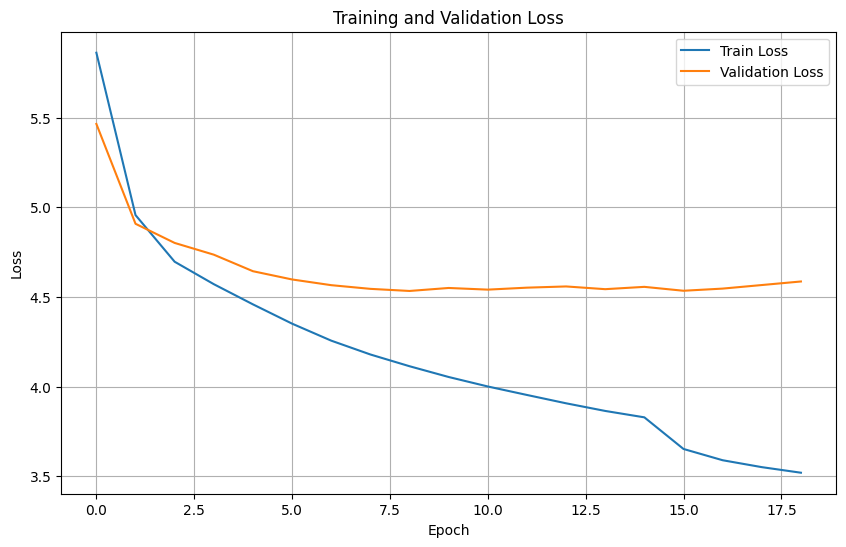

In [24]:
print("Starting Training...")
start_training_time = time.time()

best_valid_loss = float('inf')
model_save_path_best = 'empathetic-transformer-basic-best.pt' 
epochs_no_improve = 0

train_losses = []
valid_losses = []

for epoch in range(N_EPOCHS):
    epoch_start_time = time.time()
    print(f"--- Epoch {epoch+1}/{N_EPOCHS} ---")

    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    epoch_end_time = time.time()
    epoch_mins = int((epoch_end_time - epoch_start_time) / 60)
    epoch_secs = int((epoch_end_time - epoch_start_time) % 60)

    train_ppl = math.exp(train_loss) if train_loss < 100 else float('inf') 
    valid_ppl = math.exp(valid_loss) if valid_loss < 100 else float('inf')

    print(f'Epoch {epoch+1} Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:7.3f}')

    scheduler.step(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_save_path_best)
        epochs_no_improve = 0
        print(f"*** Epoch {epoch+1}: Validation loss improved. Saving best model to {model_save_path_best} ***")
    else:
        epochs_no_improve += 1
        print(f"Epoch {epoch+1}: Validation loss did not improve. ({epochs_no_improve}/{PATIENCE}) Best: {best_valid_loss:.3f}")

    if epochs_no_improve >= PATIENCE:
        print(f"\nEarly stopping triggered after {PATIENCE} epochs without validation loss improvement.")
        break 

    print("-" * 50) 

total_training_time = time.time() - start_training_time
print(f"\nTraining Finished. Total time: {total_training_time // 60:.0f}m {total_training_time % 60:.0f}s")
print(f"Best validation loss achieved: {best_valid_loss:.3f}")
print(f"Best model saved to: {model_save_path_best}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 9. Inference Function (with Sampling)
Generates responses using the trained model and various decoding strategies.

In [25]:
def generate_response_sampling(
    sentence,
    model,
    tokenizer, 
    device,
    max_len=MAX_LEN,
    strategy="topk", 
    k=10,            
    p=0.9,          
    temperature=0.8  
    ):
    """Generates a response using the transformer model with sampling."""
    assert strategy in ['greedy', 'topk', 'topp'], "Strategy must be 'greedy', 'topk', or 'topp'"
    assert temperature > 0, "Temperature must be positive"

    model.eval() 

    tokens = text_to_sequence_tokenizer(sentence, tokenizer)

    if len(tokens) > max_len:
         print(f"Warning: Input sentence truncated to {max_len} tokens.")
         tokens = tokens[:max_len]

    src_tensor = torch.LongTensor(tokens).unsqueeze(0).to(device) 
    src_mask = model.make_src_mask(src_tensor) 

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask) 

    trg_indices = [SOS_IDX] 

    for i in range(max_len - 1): 
        trg_tensor = torch.LongTensor(trg_indices).unsqueeze(0).to(device) 
        trg_mask = model.make_trg_mask(trg_tensor) 

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        pred_token_logits = output[-1, 0, :] 

        pred_token_logits = pred_token_logits / temperature

        pred_token_probs = F.softmax(pred_token_logits, dim=-1) 

        next_token_id = -1 
        if strategy == 'greedy':
            next_token_id = torch.argmax(pred_token_probs).item()
        elif strategy == 'topk':
            topk_probs, topk_indices = torch.topk(pred_token_probs, k=min(k, pred_token_probs.size(-1))) # Ensure k is not > vocab size
            mask = torch.zeros_like(pred_token_probs)
            mask.scatter_(0, topk_indices, 1.0)
            filtered_probs = pred_token_probs * mask
            sum_filtered_probs = torch.sum(filtered_probs)
            if sum_filtered_probs > 1e-9: 
                 filtered_probs = filtered_probs / sum_filtered_probs
                 next_token_id = torch.multinomial(filtered_probs, num_samples=1).item()
            else: 
                 print("Warning: Top-k resulted in zero probability sum. Using EOS.")
                 next_token_id = EOS_IDX
        elif strategy == 'topp':
            sorted_probs, sorted_indices = torch.sort(pred_token_probs, descending=True)
            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
            sorted_indices_to_remove = cumulative_probs > p
            sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
            sorted_indices_to_remove[0] = 0 
            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            pred_token_probs[indices_to_remove] = 0.0
            sum_filtered_probs = torch.sum(pred_token_probs)
            if sum_filtered_probs > 1e-9: 
                 filtered_probs = pred_token_probs / sum_filtered_probs
                 next_token_id = torch.multinomial(filtered_probs, num_samples=1).item()
            else: 
                 print("Warning: Top-p resulted in zero probability sum. Using most likely token.")
                 next_token_id = sorted_indices[0].item() 

        trg_indices.append(next_token_id)

        if next_token_id == EOS_IDX:
            break

    trg_tokens_text = sequence_to_text_tokenizer(trg_indices, tokenizer)

    return trg_tokens_text

## 10. Testing the Chatbot
Load the best model saved during training and generate responses for test prompts.

In [26]:
import torch
import torch.nn.functional as F
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.tokenize import word_tokenize
import random
from tqdm.auto import tqdm
import nltk 


def calculate_bleu(
    input_sentences, 
    target_sentences, 
    model,
    tokenizer,
    device,
    max_len=MAX_LEN,
    strategy='greedy',
    k=10,
    p=0.9,
    temperature=1.0,
    max_examples=None):
    """
    Calculates BLEU score over a dataset provided as separate input and target lists.

    Args:
        input_sentences (list): List of source sentences (strings).
        target_sentences (list): List of corresponding target/reference sentences (strings).
        model: The trained transformer model.
        tokenizer: The tokenizer instance used by the generation function.
        device: The device ('cuda' or 'cpu').
        max_len: Maximum sequence length for generation.
        strategy: Sampling strategy ('greedy', 'topk', 'topp').
        k: k for top-k sampling.
        p: p for top-p sampling.
        temperature: Temperature for sampling.
        max_examples (int, optional): Limit the number of examples to evaluate. Defaults to None (evaluate all).

    Returns:
        tuple: (corpus_bleu_score, list_of_details)
               corpus_bleu_score (float): The corpus BLEU-4 score (0.0-1.0).
               list_of_details (list): List of tuples [(source, reference, candidate, sentence_bleu), ...]
    """
    assert len(input_sentences) == len(target_sentences), \
        f"Input and target sentence lists must have the same length ({len(input_sentences)} != {len(target_sentences)})"

    targets = []     
    predictions = []  
    details = []      

    model.eval() 

    eval_data_pairs = list(zip(input_sentences, target_sentences))

    if max_examples is not None and len(eval_data_pairs) > max_examples:
        print(f"Evaluating on a random sample of {max_examples} examples.")
        eval_data_pairs = random.sample(eval_data_pairs, max_examples)
    elif max_examples is None:
         print(f"Evaluating on all {len(eval_data_pairs)} examples.")
    else: # max_examples >= len(data)
         print(f"Evaluating on all {len(eval_data_pairs)} examples (max_examples={max_examples}).")


    try:
        nltk.data.find('tokenizers/punkt')
        tokenize_for_bleu = word_tokenize
    except LookupError:
        print("NLTK 'punkt' tokenizer model not found. Downloading...")
        nltk.download('punkt')
        tokenize_for_bleu = word_tokenize
    except Exception as e:
        print(f"Could not initialize nltk.word_tokenize ({e}). Falling back to simple split().")
        tokenize_for_bleu = lambda s: s.split()


    print(f"Generating responses using strategy='{strategy}', temp={temperature}" +
          (f", k={k}" if strategy=='topk' else "") +
          (f", p={p}" if strategy=='topp' else ""))

    for source_text, target_text in tqdm(eval_data_pairs, desc="Calculating BLEU"):

        candidate_text = generate_response_sampling(
            sentence=source_text,
            model=model,
            tokenizer=tokenizer, 
            device=device,
            max_len=max_len,
            strategy=strategy,
            k=k,
            p=p,
            temperature=temperature
        )

        if candidate_text is None:
            candidate_text = "" 

        try:
            target_text_str = str(target_text) if target_text is not None else ""
            tokenized_target = [tokenize_for_bleu(target_text_str.lower())] # NLTK expects list of references
        except Exception as e:
             print(f"Warning: Error tokenizing target text '{target_text}': {e}. Using empty reference.")
             tokenized_target = [[]]
             target_text_str = "" 

        try:
            candidate_text_str = str(candidate_text) if candidate_text is not None else ""
            tokenized_candidate = tokenize_for_bleu(candidate_text_str.lower())
        except Exception as e:
            print(f"Warning: Error tokenizing candidate text '{candidate_text}': {e}. Using empty candidate.")
            tokenized_candidate = []
            candidate_text_str = "" 


        sent_bleu = 0.0
        if tokenized_candidate and tokenized_target and tokenized_target[0]:
             try:
                 sent_bleu = sentence_bleu(tokenized_target, tokenized_candidate,
                                           smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method1)
             except Exception as e:
                 print(f"Error calculating sentence BLEU for cand='{candidate_text_str}', ref='{target_text_str}': {e}")
                 sent_bleu = 0.0

        targets.append(tokenized_target)
        predictions.append(tokenized_candidate)

        details.append((source_text, target_text_str, candidate_text_str, sent_bleu))

    try:
        smoothing = nltk.translate.bleu_score.SmoothingFunction().method1
        corpus_bleu_score = corpus_bleu(targets, predictions, smoothing_function=smoothing)
    except ZeroDivisionError:
        print("Warning: ZeroDivisionError during corpus BLEU calculation. Check if predictions or references are systematically empty.")
        corpus_bleu_score = 0.0
    except Exception as e:
        print(f"Error calculating corpus BLEU: {e}")
        corpus_bleu_score = 0.0


    return corpus_bleu_score, details

print("Extracting Training pairs...")
train_inputs, train_targets = extract_pairs_corrected('train', empathetic_dialogues, subset_size=DATASET_SUBSET_SIZE)

print("\nExtracting Validation pairs...")
val_inputs, val_targets = extract_pairs_corrected('validation', empathetic_dialogues, subset_size=None) # Use full validation set

print("\nCalculating BLEU score on the VALIDATION data...")
model.to(device)
val_bleu_greedy, val_details_greedy = calculate_bleu(
    input_sentences=val_inputs,   
    target_sentences=val_targets, 
    model=model,
    tokenizer=tokenizer,
    device=device,
    max_len=MAX_LEN,
    strategy='greedy',
    temperature=1.0,
    max_examples=None 
)
print(f"\nValidation Corpus BLEU Score (Greedy): {val_bleu_greedy * 100:.2f}")

val_bleu_topp, val_details_topp = calculate_bleu(
    input_sentences=val_inputs,   
    target_sentences=val_targets, 
    model=model,
    tokenizer=tokenizer,
    device=device,
    max_len=MAX_LEN,
    strategy='topp',
    p=0.9,
    temperature=0.7,
    max_examples=None 
)
print(f"Validation Corpus BLEU Score (Top-p, p=0.9, T=0.7): {val_bleu_topp * 100:.2f}")

print("\nCalculating BLEU score on the TRAINING data...")
train_bleu_greedy, train_details_greedy = calculate_bleu(
    input_sentences=train_inputs,   
    target_sentences=train_targets, 
    model=model,
    tokenizer=tokenizer,
    device=device,
    max_len=MAX_LEN,
    strategy='greedy',
    temperature=1.0,
    max_examples=100 
)
print(f"\nTraining Corpus BLEU Score (Greedy, sample): {train_bleu_greedy * 100:.2f}")


print("\nExample Validation Generations (Top-p):")
for i, (src, ref, cand, s_bleu) in enumerate(val_details_topp[:5]): 
    print(f"--- Example {i+1} ---")
    print(f"  Source:    {src}")
    print(f"  Reference: {ref}")
    print(f"  Candidate: {cand}")
    print(f"  Sentence BLEU: {s_bleu*100:.2f}")

Extracting Training pairs...
Processing train split...
Converted train split to Pandas DataFrame with 76673 rows.
Grouped into 17844 conversations.
  Processed 10000/17844 conversations...
Finished processing train.
  Found 58829 input/target pairs.
  Skipped 64 conversations with less than 2 utterances.

Extracting Validation pairs...
Processing validation split...
Converted validation split to Pandas DataFrame with 12030 rows.
Grouped into 2763 conversations.
Finished processing validation.
  Found 9267 input/target pairs.
  Skipped 5 conversations with less than 2 utterances.

Calculating BLEU score on the VALIDATION data...
Evaluating on all 9267 examples.
Generating responses using strategy='greedy', temp=1.0


Calculating BLEU:   0%|          | 0/9267 [00:00<?, ?it/s]


Validation Corpus BLEU Score (Greedy): 1.03
Evaluating on all 9267 examples.
Generating responses using strategy='topp', temp=0.7, p=0.9


Calculating BLEU:   0%|          | 0/9267 [00:00<?, ?it/s]

Validation Corpus BLEU Score (Top-p, p=0.9, T=0.7): 0.63

Calculating BLEU score on the TRAINING data...
Evaluating on a random sample of 100 examples.
Generating responses using strategy='greedy', temp=1.0


Calculating BLEU:   0%|          | 0/100 [00:00<?, ?it/s]


Training Corpus BLEU Score (Greedy, sample): 1.07

Example Validation Generations (Top-p):
--- Example 1 ---
  Source:    My upstairs neighbors make a ton of noise at all hours of the night. It makes it difficult for me to sleep.
  Reference: That really sucks. Maybe you should try egging their door? Or just break in and pretend you're bigfoot while they're trying to sleep.
  Candidate: That is awesome ! I bet you had a good time .
  Sentence BLEU: 0.59
--- Example 2 ---
  Source:    That really sucks. Maybe you should try egging their door? Or just break in and pretend you're bigfoot while they're trying to sleep.
  Reference: I'm not trying to get arrested! I think I'll just wait things out until I move in two months.
  Candidate: I am trying to do that . I ' m just so sad .
  Sentence BLEU: 2.09
--- Example 3 ---
  Source:    I'm not trying to get arrested! I think I'll just wait things out until I move in two months.
  Reference: I would go with the bigfoot option. You can get a c

In [27]:
test_prompts = [
    "I just got a promotion at work! I'm so happy.",
    "I feel really lonely these days. No one seems to understand me.",
    "My best friend just moved to another country, and I miss them so much.",
    "I failed my exam even after studying so hard. I feel so disappointed.",
    "I helped a stranger today, and it made me feel really good.",
    "I'm really nervous about my job interview tomorrow.",
    "I just finished a marathon! I feel so accomplished.",
    "My pet passed away last night, and I’m heartbroken.",
    "I got stuck in traffic for hours today. It was so frustrating!",
    "I found out I’m going to be a parent! I’m overjoyed but also a little scared.",
    "I’ve been feeling really unmotivated lately. I don’t know what to do.",
    "I had a great conversation with an old friend today. It felt amazing!",
    "I lost my wallet today. Now I have to replace everything.",
    "I just tried a new hobby, and I think I love it!",
    "Someone criticized my work today, and it made me feel insecure.",
    "I’m struggling with my mental health, and I don’t know how to talk about it.",
    "My birthday is coming up, but I don’t feel excited this year.",
    "I finally confronted someone who hurt me in the past. It was really hard.",
    "I got my dream job! I can’t believe it’s happening.",
    "I feel so stuck in life. I don’t know what my next step should be."
]

In [28]:
print("\n--- Chatbot Test (with Sampling, Best Model) ---")

if 'model' in locals() or 'model' in globals():
    if os.path.exists(model_save_path_best): 
        print(f"Loading best model state from {model_save_path_best}...")
        try:
            model.load_state_dict(torch.load(model_save_path_best, map_location=device, weights_only=True))
            print("Model loaded successfully using weights_only=True.")
        except (RuntimeError, TypeError, KeyError) as e: 
            print(f"Could not load with weights_only=True ({e}). Trying default loading...")
            try:
                 model.load_state_dict(torch.load(model_save_path_best, map_location=device))
                 print("Model loaded successfully using default loading.")
            except Exception as e_fallback:
                 print(f"ERROR: Failed to load model state dict: {e_fallback}")
    else:
         print(f"Warning: Best model file '{model_save_path_best}' not found.")
         print("Testing with the model's current state (might be untrained or from last epoch).")

    model.to(device)

    if 'tokenizer' in locals() or 'tokenizer' in globals():
        print("\n--- Testing with Top-k (k=10, temp=0.8) ---")
        for prompt in test_prompts:
            response = generate_response_sampling(
                prompt, model, tokenizer, device, max_len=MAX_LEN, 
                strategy="topk", k=10, temperature=0.8
            )
            print(f"User: {prompt}")
            print(f"Bot:  {response}")
            print("-" * 20)

        print("\n--- Testing with Top-p (p=0.9, temp=0.8) ---")
        for prompt in test_prompts:
            response = generate_response_sampling(
                prompt, model, tokenizer, device, max_len=MAX_LEN, 
                strategy="topp", p=0.9, temperature=0.8
            )
            print(f"User: {prompt}")
            print(f"Bot:  {response}")
            print("-" * 20)
    else:
        print("ERROR: Tokenizer not found. Cannot run inference.")

else:
    print("ERROR: Model not defined. Cannot run inference.")


--- Chatbot Test (with Sampling, Best Model) ---
Loading best model state from empathetic-transformer-basic-best.pt...
Model loaded successfully using weights_only=True.

--- Testing with Top-k (k=10, temp=0.8) ---
User: I just got a promotion at work! I'm so happy.
Bot:  Wow_comma_ I ' m sorry to hear that_comma_ but that is a surprise to you are a new job to get a new fan .
--------------------
User: I feel really lonely these days. No one seems to understand me.
Bot:  Thanks . I have my friend .
--------------------
User: My best friend just moved to another country, and I miss them so much.
Bot:  That ' s good to hear . I ' m sure it ' s not too to do you think she will do the police to get it for you .
--------------------
User: I failed my exam even after studying so hard. I feel so disappointed.
Bot:  What did you get ?
--------------------
User: I helped a stranger today, and it made me feel really good.
Bot:  Oh that ' s so nice of you to do that . What ' s your son ?
-------

## 11. Final Thoughts and Limitations

*   **Tokenizer:** Using WordPiece is a significant improvement over basic splitting, handling unknown words and morphology better.
*   **Training:** Training on the full dataset with validation and early stopping is crucial for better generalization and preventing overfitting. Expect much longer training times.
*   **Model Quality:** Even with these improvements, the quality depends heavily on sufficient training time, data quality, and potentially further hyperparameter tuning or model scaling. The responses should be more coherent now, but may still lack deep understanding or perfect empathy.
*   **Safety & Evaluation:** Still lacks safety layers and proper evaluation metrics (BLEU, ROUGE, perplexity, human evaluation). This is critical for any real deployment.
*   **Next Steps:** Consider experimenting with learning rate schedulers, different optimizers (AdamW), larger model sizes (if resources allow), or more advanced attention mechanisms. For production-level quality, fine-tuning large pre-trained models is the standard approach.

# Using GloVe

In [29]:
!pip install datasets scikit-learn pandas -q

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from collections import Counter, defaultdict
import math
import random
import re
import os
import time
import numpy as np 

from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split

print(f"PyTorch Version: {torch.__version__}")

DATASET_SUBSET_SIZE = None 
MAX_LEN = 60             
MIN_FREQ = 3             

GLOVE_PATH = '/kaggle/input/glove6b300dtxt/glove.6B.300d.txt' 
EMBEDDING_DIM = 300      
FREEZE_EMBEDDINGS = False 

BATCH_SIZE = 32
LEARNING_RATE = 0.0005
N_EPOCHS = 50
CLIP = 1.0
PATIENCE = 10

D_MODEL = EMBEDDING_DIM
N_HEADS = 10             
ENC_LAYERS = 3
DEC_LAYERS = 3
PF_DIM = 512
DROPOUT = 0.3

SEED = 1234
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PAD_TOKEN = "<PAD>"
SOS_TOKEN = "<SOS>"
EOS_TOKEN = "<EOS>"
UNK_TOKEN = "<UNK>"
SPECIAL_TOKENS = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]


print("Loading EmpatheticDialogues dataset...")
try:
    empathetic_dialogues = load_dataset("empathetic_dialogues", trust_remote_code=True)
    print(empathetic_dialogues)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise e


def extract_pairs_corrected(split_name, dataset, subset_size=None):
    inputs = []
    targets = []
    data_split = dataset[split_name]
    print(f"Processing {split_name} split...")
    try:
        df = data_split.to_pandas()
        print(f"Converted {split_name} split to Pandas DataFrame with {len(df)} rows.")
        all_conv_ids = df['conv_id'].unique()
        if subset_size and subset_size < len(all_conv_ids):
            print(f"Selecting a subset of {subset_size} conversation IDs for {split_name} split.")
            selected_conv_ids = random.sample(list(all_conv_ids), subset_size)
            df = df[df['conv_id'].isin(selected_conv_ids)]
            print(f"Subset DataFrame has {len(df)} rows after filtering by conv_id.")
        grouped = df.sort_values('utterance_idx').groupby('conv_id')
        print(f"Grouped into {len(grouped)} conversations.")
        processed_convs = 0
        skipped_short_convs = 0
        for conv_id, group in grouped:
            utterances = group['utterance'].tolist()
            utterances = [u.strip() for u in utterances if u.strip()]
            if len(utterances) >= 2:
                for i in range(len(utterances) - 1):
                    inputs.append(utterances[i])
                    targets.append(utterances[i+1])
            else:
                skipped_short_convs += 1
            processed_convs += 1
            if processed_convs % 10000 == 0: print(f"  Processed {processed_convs}/{len(grouped)} conversations...")
        print(f"Finished processing {split_name}.")
        print(f"  Found {len(inputs)} input/target pairs.")
        if skipped_short_convs > 0: print(f"  Skipped {skipped_short_convs} conversations with less than 2 utterances.")
        return inputs, targets
    except ImportError: print("Error: Pandas is required."); raise
    except KeyError as e: print(f"Error: Missing expected column: {e}."); raise

print("Extracting Training pairs...")
train_inputs, train_targets = extract_pairs_corrected('train', empathetic_dialogues, subset_size=DATASET_SUBSET_SIZE)
print("\nExtracting Validation pairs...")
val_inputs, val_targets = extract_pairs_corrected('validation', empathetic_dialogues, subset_size=None)


def tokenize_words(text):
    """Simple word tokenizer: lowercase, basic punctuation, split."""
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s.,?!'-]", "", text)
    return text.split()

def build_word_vocab(texts, min_freq):
    """Builds a word vocabulary from a list of texts."""
    print("Building word vocabulary...")
    counter = Counter()
    for text in texts:
        counter.update(tokenize_words(text))

    vocab = {token: i for i, token in enumerate(SPECIAL_TOKENS)}
    idx = len(SPECIAL_TOKENS)
    word_count = 0
    for word, count in counter.items():
        if count >= min_freq:
            vocab[word] = idx
            idx += 1
            word_count += 1

    inv_vocab = {i: token for token, i in vocab.items()} 
    print(f"Vocabulary size: {len(vocab)} (min_freq={min_freq}, including {len(SPECIAL_TOKENS)} special tokens)")
    print(f"Found {word_count} words meeting min_freq={min_freq}")
    return vocab, inv_vocab

all_train_texts_words = train_inputs + train_targets
word_vocab, word_inv_vocab = build_word_vocab(all_train_texts_words, min_freq=MIN_FREQ)

PAD_IDX = word_vocab[PAD_TOKEN]
SOS_IDX = word_vocab[SOS_TOKEN]
EOS_IDX = word_vocab[EOS_TOKEN]
UNK_IDX = word_vocab[UNK_TOKEN]
print(f"Word Token IDs: PAD={PAD_IDX}, SOS={SOS_IDX}, EOS={EOS_IDX}, UNK={UNK_IDX}")

INPUT_DIM = len(word_vocab)
OUTPUT_DIM = INPUT_DIM


print(f"Loading GloVe vectors from {GLOVE_PATH}...")
embeddings_index = {}
loaded_vectors = 0
try:
    with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if len(values[1:]) == EMBEDDING_DIM:
                try:
                    coefs = np.asarray(values[1:], dtype='float32')
                    embeddings_index[word] = coefs
                    loaded_vectors += 1
                except ValueError:
                    pass

    print(f"Loaded {loaded_vectors} word vectors.")
    if loaded_vectors == 0:
        print("ERROR: No vectors loaded. Check GloVe path and dimension.")
except FileNotFoundError:
    print(f"ERROR: GloVe file not found at {GLOVE_PATH}. Cannot load pre-trained embeddings.")
    embeddings_index = {} 


print("Creating embedding matrix...")
embedding_matrix = np.random.uniform(-0.05, 0.05, (INPUT_DIM, EMBEDDING_DIM))
embedding_matrix = embedding_matrix.astype(np.float32) 

hits = 0
misses = 0
for word, i in word_vocab.items():
    if i == PAD_IDX:
        embedding_matrix[i] = np.zeros(EMBEDDING_DIM, dtype=np.float32)
        hits += 1 
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    elif word.lower() in embeddings_index:
         embedding_matrix[i] = embeddings_index[word.lower()]
         hits += 1
    else:
        misses += 1

print(f"Initialized embedding matrix for {INPUT_DIM} words.")
print(f"  Found pre-trained vectors for {hits} words in vocab.")
print(f"  {misses} words in vocab not found in GloVe (using random init).")

embedding_matrix = torch.FloatTensor(embedding_matrix)

del embeddings_index
import gc
gc.collect()
print("Cleaned up GloVe index.")


def text_to_sequence_words(text, vocab):
    tokens = tokenize_words(text)
    return [SOS_IDX] + [vocab.get(token, UNK_IDX) for token in tokens] + [EOS_IDX]

def sequence_to_text_words(sequence, inv_vocab):
    tokens = [inv_vocab.get(idx, UNK_TOKEN) for idx in sequence if idx not in [PAD_IDX, SOS_IDX, EOS_IDX]]
    return " ".join(tokens)

def pad_sequence(seq, max_len, pad_idx):
    seq = seq[:max_len]
    padded = seq + [pad_idx] * (max_len - len(seq))
    return padded

def process_data_words(inputs, targets, vocab, max_len, pad_idx):
    print(f"Tokenizing (words) and padding sequences (MAX_LEN={max_len})...")
    processed_count = 0
    total_pairs = len(inputs)
    tokenized_inputs = []
    tokenized_targets = []
    for i in range(total_pairs):
        tokenized_inputs.append(text_to_sequence_words(inputs[i], vocab))
        tokenized_targets.append(text_to_sequence_words(targets[i], vocab))
        processed_count += 1
        if processed_count % 10000 == 0: print(f"  Processed {processed_count}/{total_pairs} pairs...")

    print("Padding sequences...")
    padded_inputs = [pad_sequence(seq, max_len, pad_idx) for seq in tokenized_inputs]
    padded_targets = [pad_sequence(seq, max_len, pad_idx) for seq in tokenized_targets]
    print("Padding complete.")
    return padded_inputs, padded_targets

padded_train_inputs, padded_train_targets = process_data_words(train_inputs, train_targets, word_vocab, MAX_LEN, PAD_IDX)
padded_val_inputs, padded_val_targets = process_data_words(val_inputs, val_targets, word_vocab, MAX_LEN, PAD_IDX)

class DialogueDataset(Dataset):
    def __init__(self, inputs, targets):
        assert len(inputs) > 0, "Input list empty!"
        assert len(inputs) == len(targets), "Input/target length mismatch!"
        self.inputs = torch.tensor(inputs, dtype=torch.long)
        self.targets = torch.tensor(targets, dtype=torch.long)
        print(f"DialogueDataset created with {len(self.inputs)} samples.")
    def __len__(self): return len(self.inputs)
    def __getitem__(self, idx): return self.inputs[idx], self.targets[idx]

try:
    train_dataset = DialogueDataset(padded_train_inputs, padded_train_targets)
    val_dataset = DialogueDataset(padded_val_inputs, padded_val_targets)
except AssertionError as e: print(f"Error creating dataset: {e}"); raise e

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True if device=='cuda' else False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True if device=='cuda' else False)
print(f"Created Train DataLoader ({len(train_loader)} batches)")
print(f"Created Validation DataLoader ({len(val_loader)} batches)")

try:
    del padded_train_inputs, padded_train_targets, padded_val_inputs, padded_val_targets
    del train_inputs, train_targets, val_inputs, val_targets, all_train_texts_words
    gc.collect(); print("Cleaned up intermediate data lists.")
except NameError: print("Intermediate lists cleanup skipped or already done.")

class PositionalEncoding(nn.Module):
    """Injects positional information into the input embeddings."""
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class MultiHeadAttention(nn.Module):
    """Multi-Head Attention mechanism."""
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("scale", torch.sqrt(torch.FloatTensor([self.head_dim])))
    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[1]
        Q = self.fc_q(query); K = self.fc_k(key); V = self.fc_v(value)
        Q = Q.view(query.shape[0], batch_size, self.n_heads, self.head_dim).permute(1, 2, 0, 3)
        K = K.view(key.shape[0], batch_size, self.n_heads, self.head_dim).permute(1, 2, 0, 3)
        V = V.view(value.shape[0], batch_size, self.n_heads, self.head_dim).permute(1, 2, 0, 3)
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale.to(Q.device)
        if mask is not None: energy = energy.masked_fill(mask == 0, -1e10)
        attention = torch.softmax(energy, dim=-1)
        attention = self.dropout(attention)
        x = torch.matmul(attention, V)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, query.shape[0], self.d_model)
        x = x.permute(1, 0, 2)
        x = self.fc_o(x)
        return x, attention

class PositionwiseFeedforward(nn.Module):
    """Position-wise Feedforward Network."""
    def __init__(self, d_model, pf_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, pf_dim)
        self.fc2 = nn.Linear(pf_dim, d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

class EncoderLayer(nn.Module):
    """A single layer of the Transformer Encoder."""
    def __init__(self, d_model, n_heads, pf_dim, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ff = PositionwiseFeedforward(d_model, pf_dim, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, src, src_mask):
        _src, _ = self.self_attn(src, src, src, src_mask)
        src = self.norm1(src + self.dropout(_src))
        _src = self.ff(src)
        src = self.norm2(src + self.dropout(_src))
        return src

class DecoderLayer(nn.Module):
    """A single layer of the Transformer Decoder."""
    def __init__(self, d_model, n_heads, pf_dim, dropout=0.1):
        super().__init__()
        self.masked_self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.encoder_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ff = PositionwiseFeedforward(d_model, pf_dim, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, trg, enc_src, trg_mask, src_mask):
        _trg, _ = self.masked_self_attn(trg, trg, trg, trg_mask)
        trg = self.norm1(trg + self.dropout(_trg))
        _trg, attention = self.encoder_attn(trg, enc_src, enc_src, src_mask)
        trg = self.norm2(trg + self.dropout(_trg))
        _trg = self.ff(trg)
        trg = self.norm3(trg + self.dropout(_trg))
        return trg, attention

class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, n_layers, n_heads, pf_dim, dropout,
                 pretrained_embeddings, freeze_embeddings, max_len=MAX_LEN): 
        super().__init__()
        self.tok_embedding = nn.Embedding(input_dim, d_model)
        self.tok_embedding.weight.data.copy_(pretrained_embeddings)
        if freeze_embeddings:
            self.tok_embedding.weight.requires_grad = False
            print("Encoder embeddings frozen.")
        else:
            print("Encoder embeddings will be fine-tuned.")
        self.pos_embedding = PositionalEncoding(d_model, dropout, max_len=5000 if max_len < 5000 else max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, pf_dim, dropout) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("scale", torch.sqrt(torch.FloatTensor([d_model])))

    def forward(self, src, src_mask):
        scale = self.scale.to(src.device)
        src = self.dropout((self.tok_embedding(src) * scale)) 
        src = src.permute(1, 0, 2)
        src = self.pos_embedding(src)
        for layer in self.layers: src = layer(src, src_mask)
        return src

class Decoder(nn.Module):
    def __init__(self, output_dim, d_model, n_layers, n_heads, pf_dim, dropout,
                 pretrained_embeddings, freeze_embeddings, max_len=MAX_LEN): 
        super().__init__()
        self.tok_embedding = nn.Embedding(output_dim, d_model)
        self.tok_embedding.weight.data.copy_(pretrained_embeddings)
        if freeze_embeddings:
            self.tok_embedding.weight.requires_grad = False
            print("Decoder embeddings frozen.")
        else:
            print("Decoder embeddings will be fine-tuned.")
        self.pos_embedding = PositionalEncoding(d_model, dropout, max_len=5000 if max_len < 5000 else max_len)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, pf_dim, dropout) for _ in range(n_layers)])
        self.fc_out = nn.Linear(d_model, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("scale", torch.sqrt(torch.FloatTensor([d_model])))

    def forward(self, trg, enc_src, trg_mask, src_mask):
        scale = self.scale.to(trg.device)
        trg = self.dropout((self.tok_embedding(trg) * scale)) 
        trg = trg.permute(1, 0, 2)
        trg = self.pos_embedding(trg)
        for layer in self.layers: trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        output = self.fc_out(trg)
        return output, attention

class Seq2SeqTransformer(nn.Module):
    """The main Seq2Seq Transformer model."""
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask.to(self.device)
    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()
        trg_mask = trg_pad_mask & trg_sub_mask
        return trg_mask.to(self.device)
    def forward(self, src, trg):
        src = src.to(self.device); trg = trg.to(self.device)
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        return output, attention


print("Initializing model components with GloVe embeddings...")
enc = Encoder(INPUT_DIM, D_MODEL, ENC_LAYERS, N_HEADS, PF_DIM, DROPOUT,
              embedding_matrix, FREEZE_EMBEDDINGS, MAX_LEN).to(device)
dec = Decoder(OUTPUT_DIM, D_MODEL, DEC_LAYERS, N_HEADS, PF_DIM, DROPOUT,
              embedding_matrix, FREEZE_EMBEDDINGS, MAX_LEN).to(device)

model = Seq2SeqTransformer(enc, dec, PAD_IDX, PAD_IDX, device).to(device)

def initialize_non_embedding_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1 and not isinstance(m, nn.Embedding):
        nn.init.xavier_uniform_(m.weight.data)
    if isinstance(m, nn.Linear) and m.bias is not None:
        nn.init.constant_(m.bias, 0)

print("Applying Xavier uniform initialization to non-embedding layers...")
model.apply(initialize_non_embedding_weights)

params_to_optimize = model.parameters() if not FREEZE_EMBEDDINGS else filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.AdamW(params_to_optimize, lr=LEARNING_RATE) 

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX) 


def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters.')
print(f"Model is on device: {next(model.parameters()).device}")

del embedding_matrix
gc.collect()
print("Cleaned up embedding matrix.")


def train(model, iterator, optimizer, criterion, clip):
    """Performs one epoch of training."""
    model.train(); epoch_loss = 0; num_batches = len(iterator)
    for i, batch in enumerate(iterator):
        src, trg = batch
        src, trg = src.to(device, non_blocking=True), trg.to(device, non_blocking=True)
        optimizer.zero_grad()
        trg_input = trg[:, :-1]; trg_output_expected = trg[:, 1:].contiguous()
        output, _ = model(src, trg_input)
        output_dim = output.shape[-1]
        output = output.permute(1, 0, 2).contiguous().view(-1, output_dim)
        trg_output_expected = trg_output_expected.view(-1)
        loss = criterion(output, trg_output_expected)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / num_batches

def evaluate(model, iterator, criterion):
    """Performs one epoch of evaluation."""
    model.eval(); epoch_loss = 0; num_batches = len(iterator)
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src, trg = batch
            src, trg = src.to(device, non_blocking=True), trg.to(device, non_blocking=True)
            trg_input = trg[:, :-1]; trg_output_expected = trg[:, 1:].contiguous()
            output, _ = model(src, trg_input)
            output_dim = output.shape[-1]
            output = output.permute(1, 0, 2).contiguous().view(-1, output_dim)
            trg_output_expected = trg_output_expected.view(-1)
            loss = criterion(output, trg_output_expected)
            epoch_loss += loss.item()
    return epoch_loss / num_batches


print("Starting Training...")
start_training_time = time.time()
best_valid_loss = float('inf')
model_save_path_best = 'glove-transformer-basic-best.pt' 
epochs_no_improve = 0
train_losses = []; valid_losses = []

for epoch in range(N_EPOCHS):
    epoch_start_time = time.time()
    print(f"--- Epoch {epoch+1}/{N_EPOCHS} ---")
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss); valid_losses.append(valid_loss)
    epoch_end_time = time.time()
    epoch_mins = int((epoch_end_time - epoch_start_time) / 60)
    epoch_secs = int((epoch_end_time - epoch_start_time) % 60)
    train_ppl = math.exp(train_loss) if train_loss < 100 else float('inf')
    valid_ppl = math.exp(valid_loss) if valid_loss < 100 else float('inf')
    print(f'Epoch {epoch+1} Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:7.3f}')
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_save_path_best)
        epochs_no_improve = 0
        print(f"*** Epoch {epoch+1}: Validation loss improved. Saving best model to {model_save_path_best} ***")
    else:
        epochs_no_improve += 1
        print(f"Epoch {epoch+1}: Validation loss did not improve. ({epochs_no_improve}/{PATIENCE}) Best: {best_valid_loss:.3f}")
    if epochs_no_improve >= PATIENCE:
        print(f"\nEarly stopping triggered after {PATIENCE} epochs without validation loss improvement.")
        break
    print("-" * 50)

total_training_time = time.time() - start_training_time
print(f"\nTraining Finished. Total time: {total_training_time // 60:.0f}m {total_training_time % 60:.0f}s")
print(f"Best validation loss achieved: {best_valid_loss:.3f}")
print(f"Best model saved to: {model_save_path_best}")

def generate_response_sampling_words( 
    sentence,
    model,
    vocab,       
    inv_vocab,   
    device,
    max_len=MAX_LEN,
    strategy="topk",
    k=10,
    p=0.9,
    temperature=0.8
    ):
    assert strategy in ['greedy', 'topk', 'topp']
    assert temperature > 0
    model.eval()

    tokens = text_to_sequence_words(sentence, vocab) 
    if len(tokens) > max_len: tokens = tokens[:max_len]
    src_tensor = torch.LongTensor(tokens).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad(): enc_src = model.encoder(src_tensor, src_mask)

    trg_indices = [SOS_IDX]
    for i in range(max_len - 1):
        trg_tensor = torch.LongTensor(trg_indices).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad(): output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_token_logits = output[-1, 0, :]
        pred_token_logits = pred_token_logits / temperature
        pred_token_probs = F.softmax(pred_token_logits, dim=-1)

        next_token_id = -1
        if strategy == 'greedy': next_token_id = torch.argmax(pred_token_probs).item()
        elif strategy == 'topk':
            topk_probs, topk_indices = torch.topk(pred_token_probs, k=min(k, pred_token_probs.size(-1)))
            mask = torch.zeros_like(pred_token_probs); mask.scatter_(0, topk_indices, 1.0)
            filtered_probs = pred_token_probs * mask
            sum_filtered_probs = torch.sum(filtered_probs)
            if sum_filtered_probs > 1e-9:
                 filtered_probs = filtered_probs / sum_filtered_probs
                 next_token_id = torch.multinomial(filtered_probs, num_samples=1).item()
            else: print("Warning: Top-k zero sum."); next_token_id = EOS_IDX
        elif strategy == 'topp':
            sorted_probs, sorted_indices = torch.sort(pred_token_probs, descending=True)
            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
            sorted_indices_to_remove = cumulative_probs > p
            sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone(); sorted_indices_to_remove[0] = 0
            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            pred_token_probs[indices_to_remove] = 0.0
            sum_filtered_probs = torch.sum(pred_token_probs)
            if sum_filtered_probs > 1e-9:
                 filtered_probs = pred_token_probs / sum_filtered_probs
                 next_token_id = torch.multinomial(filtered_probs, num_samples=1).item()
            else: print("Warning: Top-p zero sum."); next_token_id = sorted_indices[0].item()

        trg_indices.append(next_token_id)
        if next_token_id == EOS_IDX: break

    trg_tokens_text = sequence_to_text_words(trg_indices, inv_vocab) 
    return trg_tokens_text

import torch
import torch.nn.functional as F
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.tokenize import word_tokenize
import random
from tqdm.auto import tqdm
import nltk 


def calculate_bleu(
    input_sentences, 
    target_sentences, 
    model,
    tokenizer,
    device,
    max_len=MAX_LEN,
    strategy='greedy',
    k=10,
    p=0.9,
    temperature=1.0,
    max_examples=None):
    """
    Calculates BLEU score over a dataset provided as separate input and target lists.

    Args:
        input_sentences (list): List of source sentences (strings).
        target_sentences (list): List of corresponding target/reference sentences (strings).
        model: The trained transformer model.
        tokenizer: The tokenizer instance used by the generation function.
        device: The device ('cuda' or 'cpu').
        max_len: Maximum sequence length for generation.
        strategy: Sampling strategy ('greedy', 'topk', 'topp').
        k: k for top-k sampling.
        p: p for top-p sampling.
        temperature: Temperature for sampling.
        max_examples (int, optional): Limit the number of examples to evaluate. Defaults to None (evaluate all).

    Returns:
        tuple: (corpus_bleu_score, list_of_details)
               corpus_bleu_score (float): The corpus BLEU-4 score (0.0-1.0).
               list_of_details (list): List of tuples [(source, reference, candidate, sentence_bleu), ...]
    """
    assert len(input_sentences) == len(target_sentences), \
        f"Input and target sentence lists must have the same length ({len(input_sentences)} != {len(target_sentences)})"

    targets = []     
    predictions = [] 
    details = []      

    model.eval() 

    eval_data_pairs = list(zip(input_sentences, target_sentences))

    if max_examples is not None and len(eval_data_pairs) > max_examples:
        print(f"Evaluating on a random sample of {max_examples} examples.")
        eval_data_pairs = random.sample(eval_data_pairs, max_examples)
    elif max_examples is None:
         print(f"Evaluating on all {len(eval_data_pairs)} examples.")
    else: # max_examples >= len(data)
         print(f"Evaluating on all {len(eval_data_pairs)} examples (max_examples={max_examples}).")


    try:
        nltk.data.find('tokenizers/punkt')
        tokenize_for_bleu = word_tokenize
    except LookupError:
        print("NLTK 'punkt' tokenizer model not found. Downloading...")
        nltk.download('punkt')
        tokenize_for_bleu = word_tokenize
    except Exception as e:
        print(f"Could not initialize nltk.word_tokenize ({e}). Falling back to simple split().")
        tokenize_for_bleu = lambda s: s.split()


    print(f"Generating responses using strategy='{strategy}', temp={temperature}" +
          (f", k={k}" if strategy=='topk' else "") +
          (f", p={p}" if strategy=='topp' else ""))

    for source_text, target_text in tqdm(eval_data_pairs, desc="Calculating BLEU"):

        candidate_text = generate_response_sampling(
            sentence=source_text,
            model=model,
            tokenizer=tokenizer, 
            device=device,
            max_len=max_len,
            strategy=strategy,
            k=k,
            p=p,
            temperature=temperature
        )

        if candidate_text is None:
            candidate_text = "" 

        try:
            target_text_str = str(target_text) if target_text is not None else ""
            tokenized_target = [tokenize_for_bleu(target_text_str.lower())] 
        except Exception as e:
             print(f"Warning: Error tokenizing target text '{target_text}': {e}. Using empty reference.")
             tokenized_target = [[]]
             target_text_str = "" 

        try:
            candidate_text_str = str(candidate_text) if candidate_text is not None else ""
            tokenized_candidate = tokenize_for_bleu(candidate_text_str.lower())
        except Exception as e:
            print(f"Warning: Error tokenizing candidate text '{candidate_text}': {e}. Using empty candidate.")
            tokenized_candidate = []
            candidate_text_str = "" 


        sent_bleu = 0.0
        if tokenized_candidate and tokenized_target and tokenized_target[0]:
             try:
                 sent_bleu = sentence_bleu(tokenized_target, tokenized_candidate,
                                           smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method1)
             except Exception as e:
                 print(f"Error calculating sentence BLEU for cand='{candidate_text_str}', ref='{target_text_str}': {e}")
                 sent_bleu = 0.0

        targets.append(tokenized_target)
        predictions.append(tokenized_candidate)

        details.append((source_text, target_text_str, candidate_text_str, sent_bleu))

    try:
        smoothing = nltk.translate.bleu_score.SmoothingFunction().method1
        corpus_bleu_score = corpus_bleu(targets, predictions, smoothing_function=smoothing)
    except ZeroDivisionError:
        print("Warning: ZeroDivisionError during corpus BLEU calculation. Check if predictions or references are systematically empty.")
        corpus_bleu_score = 0.0
    except Exception as e:
        print(f"Error calculating corpus BLEU: {e}")
        corpus_bleu_score = 0.0


    return corpus_bleu_score, details

# print("Extracting Training pairs...")
# train_inputs, train_targets = extract_pairs_corrected('train', empathetic_dialogues, subset_size=DATASET_SUBSET_SIZE)

# print("\nExtracting Validation pairs...")
# val_inputs, val_targets = extract_pairs_corrected('validation', empathetic_dialogues, subset_size=None) 

# print("\nCalculating BLEU score on the VALIDATION data...")
# model.to(device)
# val_bleu_greedy, val_details_greedy = calculate_bleu(
#     input_sentences=val_inputs,   
#     target_sentences=val_targets, 
#     model=model,
#     tokenizer=tokenizer,
#     device=device,
#     max_len=MAX_LEN,
#     strategy='greedy',
#     temperature=1.0,
#     max_examples=100 
# )
# print(f"\nValidation Corpus BLEU Score (Greedy): {val_bleu_greedy * 100:.2f}")

# val_bleu_topp, val_details_topp = calculate_bleu(
#     input_sentences=val_inputs[:100],   
#     target_sentences=val_targets[:100], 
#     model=model,
#     tokenizer=tokenizer,
#     device=device,
#     max_len=MAX_LEN,
#     strategy='topp',
#     p=0.9,
#     temperature=0.7,
#     max_examples=100 
# )
# print(f"Validation Corpus BLEU Score (Top-p, p=0.9, T=0.7): {val_bleu_topp * 100:.2f}")

# print("\nCalculating BLEU score on the TRAINING data...")
# train_bleu_greedy, train_details_greedy = calculate_bleu(
#     input_sentences=train_inputs[:100],   
#     target_sentences=train_targets[:100], 
#     model=model,
#     tokenizer=tokenizer,
#     device=device,
#     max_len=MAX_LEN,
#     strategy='greedy',
#     temperature=1.0,
#     max_examples=100 
# )
# print(f"\nTraining Corpus BLEU Score (Greedy, sample): {train_bleu_greedy * 100:.2f}")


# print("\nExample Validation Generations (Top-p):")
# for i, (src, ref, cand, s_bleu) in enumerate(val_details_topp[:5]): 
#     print(f"--- Example {i+1} ---")
#     print(f"  Source:    {src}")
#     print(f"  Reference: {ref}")
#     print(f"  Candidate: {cand}")
#     print(f"  Sentence BLEU: {s_bleu*100:.2f}")
test_prompts = [
    "I just got a promotion at work! I'm so happy.",
    "I feel really lonely these days. No one seems to understand me.",
    "My best friend just moved to another country, and I miss them so much.",
    "I failed my exam even after studying so hard. I feel so disappointed.",
    "I helped a stranger today, and it made me feel really good.",
    "I'm really nervous about my job interview tomorrow.",
]

print("\n--- Chatbot Test (GloVe Embeddings, Best Model) ---")

if 'model' in locals() or 'model' in globals():
    if os.path.exists(model_save_path_best):
        print(f"Loading best model state from {model_save_path_best}...")
        try:
            model.load_state_dict(torch.load(model_save_path_best, map_location=device, weights_only=True))
            print("Model loaded successfully (weights_only=True).")
        except Exception as e:
            print(f"Could not load with weights_only=True ({e}). Trying default...")
            try:
                 model.load_state_dict(torch.load(model_save_path_best, map_location=device))
                 print("Model loaded successfully (default).")
            except Exception as e_fallback: print(f"ERROR loading model: {e_fallback}"); raise e_fallback
    else:
         print(f"Warning: Best model file '{model_save_path_best}' not found. Using current model state.")
    model.to(device) # Ensure model is on correct device

    # --- Run Tests ---
    if 'word_vocab' in locals() and 'word_inv_vocab' in locals():
        print("\n--- Testing with Top-k (k=10, temp=0.8) ---")
        for prompt in test_prompts:
            response = generate_response_sampling_words( 
                prompt, model, word_vocab, word_inv_vocab, device, max_len=MAX_LEN,
                strategy="topk", k=10, temperature=0.8
            )
            print(f"User: {prompt}")
            print(f"Bot:  {response}")
            print("-" * 20)

        print("\n--- Testing with Top-p (p=0.9, temp=0.8) ---")
        for prompt in test_prompts:
            response = generate_response_sampling_words( 
                prompt, model, word_vocab, word_inv_vocab, device, max_len=MAX_LEN,
                strategy="topp", p=0.9, temperature=0.8
            )
            print(f"User: {prompt}")
            print(f"Bot:  {response}")
            print("-" * 20)
    else:
        print("ERROR: Word vocabulary not found. Cannot run inference.")
else:
    print("ERROR: Model not defined. Cannot run inference.")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


PyTorch Version: 2.5.1+cu124
Using device: cuda
Loading EmpatheticDialogues dataset...
DatasetDict({
    train: Dataset({
        features: ['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags'],
        num_rows: 76673
    })
    validation: Dataset({
        features: ['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags'],
        num_rows: 12030
    })
    test: Dataset({
        features: ['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags'],
        num_rows: 10943
    })
})
Dataset loaded successfully.
Extracting Training pairs...
Processing train split...
Converted train split to Pandas DataFrame with 76673 rows.
Grouped into 17844 conversations.
  Processed 10000/17844 conversations...
Finished processing train.
  Found 58829 input/target pairs.
  Skipped 64 conversations with less than 2 utterances.

Extracting Validation pairs...
Processing validat

# Using Fastext

# Basic Mental Health Chatbot with Transformer (From Scratch) - FastText Embeddings

**Improvements:**
*   Uses pre-trained FastText word embeddings (good OOV handling).
*   Uses a word-level tokenizer.
*   Includes validation loop and early stopping.
*   Saves the best model based on validation performance.
*   Sampling strategies (Top-k, Top-p) for inference.

**Disclaimer:** Educational example, NOT for real mental health support. Requires FastText file download and upload to Kaggle Datasets. Training time depends on data size and compute resources.

In [30]:
!pip install datasets scikit-learn pandas -q

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau 

from collections import Counter, defaultdict
import math
import random
import re
import os
import time
import numpy as np 
import gc 

from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split

print(f"PyTorch Version: {torch.__version__}")
try:
    import datasets, sklearn, pandas
    print("Core libraries loaded.")
except ImportError as e:
    print(f"Error importing libraries: {e}. Please ensure installs were successful.")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


PyTorch Version: 2.5.1+cu124
Core libraries loaded.


In [31]:
DATASET_SUBSET_SIZE = None 
MAX_LEN = 60             
MIN_FREQ = 3             

FASTTEXT_PATH = '/kaggle/input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'

EMBEDDING_DIM = 300
FREEZE_EMBEDDINGS = False 

BATCH_SIZE = 64          
LEARNING_RATE = 0.0005
N_EPOCHS = 50            
CLIP = 1.0
PATIENCE = 10            

D_MODEL = EMBEDDING_DIM
N_HEADS = 10
ENC_LAYERS = 3
DEC_LAYERS = 3
PF_DIM = 512             
DROPOUT = 0.3         

SEED = 1234
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define Special Tokens
PAD_TOKEN = "<PAD>"
SOS_TOKEN = "<SOS>"
EOS_TOKEN = "<EOS>"
UNK_TOKEN = "<UNK>"
SPECIAL_TOKENS = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]

Using device: cuda


## 1. Load EmpatheticDialogues Dataset

In [32]:
print("Loading EmpatheticDialogues dataset...")
try:
    empathetic_dialogues = load_dataset("empathetic_dialogues", trust_remote_code=True)
    print(empathetic_dialogues)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise e

Loading EmpatheticDialogues dataset...
DatasetDict({
    train: Dataset({
        features: ['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags'],
        num_rows: 76673
    })
    validation: Dataset({
        features: ['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags'],
        num_rows: 12030
    })
    test: Dataset({
        features: ['conv_id', 'utterance_idx', 'context', 'prompt', 'speaker_idx', 'utterance', 'selfeval', 'tags'],
        num_rows: 10943
    })
})
Dataset loaded successfully.


## 2. Extract Conversation Pairs
Group utterances by conversation ID and create input/target pairs from adjacent turns.

In [33]:
def extract_pairs_corrected(split_name, dataset, subset_size=None):
    """Extracts adjacent utterance pairs from a given split of the dataset."""
    inputs = []
    targets = []
    data_split = dataset[split_name]
    print(f"Processing {split_name} split...")
    try:
        df = data_split.to_pandas()
        print(f"Converted {split_name} split to Pandas DataFrame with {len(df)} rows.")

        all_conv_ids = df['conv_id'].unique()
        if subset_size and subset_size < len(all_conv_ids):
            print(f"Selecting a subset of {subset_size} conversation IDs for {split_name} split.")
            selected_conv_ids = random.sample(list(all_conv_ids), subset_size)
            df = df[df['conv_id'].isin(selected_conv_ids)]
            print(f"Subset DataFrame has {len(df)} rows after filtering by conv_id.")

        grouped = df.sort_values('utterance_idx').groupby('conv_id')
        print(f"Grouped into {len(grouped)} conversations.")

        processed_convs = 0
        skipped_short_convs = 0
        for conv_id, group in grouped:
            utterances = group['utterance'].tolist()
            utterances = [u.strip() for u in utterances if u.strip()] 

            if len(utterances) >= 2:
                for i in range(len(utterances) - 1):
                    inputs.append(utterances[i])
                    targets.append(utterances[i+1])
            else:
                skipped_short_convs += 1

            processed_convs += 1
            if processed_convs % 10000 == 0:
                 print(f"  Processed {processed_convs}/{len(grouped)} conversations...")

        print(f"Finished processing {split_name}.")
        print(f"  Found {len(inputs)} input/target pairs.")
        if skipped_short_convs > 0:
            print(f"  Skipped {skipped_short_convs} conversations with less than 2 utterances.")
        return inputs, targets

    except ImportError:
        print("Error: Pandas is required for data extraction. Please install it.")
        raise
    except KeyError as e:
        print(f"Error: Missing expected column in dataset: {e}. Check dataset structure.")
        raise

In [34]:
print("Extracting Training pairs...")
train_inputs, train_targets = extract_pairs_corrected('train', empathetic_dialogues, subset_size=DATASET_SUBSET_SIZE)

print("\nExtracting Validation pairs...")
val_inputs, val_targets = extract_pairs_corrected('validation', empathetic_dialogues, subset_size=None) # Use full validation set

Extracting Training pairs...
Processing train split...
Converted train split to Pandas DataFrame with 76673 rows.
Grouped into 17844 conversations.
  Processed 10000/17844 conversations...
Finished processing train.
  Found 58829 input/target pairs.
  Skipped 64 conversations with less than 2 utterances.

Extracting Validation pairs...
Processing validation split...
Converted validation split to Pandas DataFrame with 12030 rows.
Grouped into 2763 conversations.
Finished processing validation.
  Found 9267 input/target pairs.
  Skipped 5 conversations with less than 2 utterances.


## 3. Word Tokenizer and Vocabulary Building
Using a simple word-level tokenizer and building vocabulary based on word frequency.

In [35]:
def tokenize_words(text):
    """Simple word tokenizer: lowercase, basic punctuation, split."""
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s.,?!'-]", "", text)
    tokens = text.split()
    return [token for token in tokens if token] 

def build_word_vocab(texts, min_freq):
    """Builds a word vocabulary from a list of texts."""
    print("Building word vocabulary...")
    counter = Counter()
    processed_texts = 0
    for text in texts:
        counter.update(tokenize_words(text))
        processed_texts += 1
        if processed_texts % 10000 == 0:
            print(f"  Processed {processed_texts}/{len(texts)} texts for vocab counting...")


    vocab = {token: i for i, token in enumerate(SPECIAL_TOKENS)}
    idx = len(SPECIAL_TOKENS)
    word_count = 0
    for word, count in sorted(counter.items()):
        if count >= min_freq:
            if word not in vocab: 
                vocab[word] = idx
                idx += 1
                word_count += 1

    inv_vocab = {i: token for token, i in vocab.items()} 
    print(f"Vocabulary size: {len(vocab)} (min_freq={min_freq}, including {len(SPECIAL_TOKENS)} special tokens)")
    print(f"Found {word_count} words meeting min_freq={min_freq}")
    return vocab, inv_vocab

In [36]:
all_train_texts_words = train_inputs + train_targets
word_vocab, word_inv_vocab = build_word_vocab(all_train_texts_words, min_freq=MIN_FREQ)

PAD_IDX = word_vocab.get(PAD_TOKEN) 
SOS_IDX = word_vocab.get(SOS_TOKEN)
EOS_IDX = word_vocab.get(EOS_TOKEN)
UNK_IDX = word_vocab.get(UNK_TOKEN)

if None in [PAD_IDX, SOS_IDX, EOS_IDX, UNK_IDX]:
    raise ValueError("Error: One or more special tokens not found in vocabulary!")
else:
    print(f"Word Token IDs: PAD={PAD_IDX}, SOS={SOS_IDX}, EOS={EOS_IDX}, UNK={UNK_IDX}")

INPUT_DIM = len(word_vocab)
OUTPUT_DIM = INPUT_DIM

Building word vocabulary...
  Processed 10000/117658 texts for vocab counting...
  Processed 20000/117658 texts for vocab counting...
  Processed 30000/117658 texts for vocab counting...
  Processed 40000/117658 texts for vocab counting...
  Processed 50000/117658 texts for vocab counting...
  Processed 60000/117658 texts for vocab counting...
  Processed 70000/117658 texts for vocab counting...
  Processed 80000/117658 texts for vocab counting...
  Processed 90000/117658 texts for vocab counting...
  Processed 100000/117658 texts for vocab counting...
  Processed 110000/117658 texts for vocab counting...
Vocabulary size: 16041 (min_freq=3, including 4 special tokens)
Found 16037 words meeting min_freq=3
Word Token IDs: PAD=0, SOS=1, EOS=2, UNK=3


## 4. Load Pre-trained FastText Embeddings
Load word vectors from the specified FastText file. Ensure the path and dimension match your uploaded file.

In [37]:
print(f"Loading FastText vectors from {FASTTEXT_PATH}...")
embeddings_index = {}
loaded_vectors = 0
skipped_lines = 0
lines_to_skip = 1 

try:
    with open(FASTTEXT_PATH, 'r', encoding='utf-8') as f:
        for i in range(lines_to_skip):
            try:
                header = next(f)
                print(f"Skipped header line: {header.strip()}")
            except StopIteration:
                print("Warning: File seems empty or has no header to skip.")
                break

        ln = lines_to_skip
        for line in f:
            ln += 1
            values = line.rstrip().split(' ') 
            if len(values) == EMBEDDING_DIM + 1:
                 word = values[0]
                 try:
                     coefs = np.asarray(values[1:], dtype='float32')
                     embeddings_index[word] = coefs
                     loaded_vectors += 1
                 except ValueError:
                     skipped_lines += 1
                     pass
            else:
                 skipped_lines += 1


    print(f"\nLoaded {loaded_vectors} word vectors.")
    if skipped_lines > 0:
        print(f"Skipped {skipped_lines} lines due to parsing errors or incorrect dimensions.")
    if loaded_vectors == 0:
        print("ERROR: No vectors loaded. Check FastText path, dimension, and file format.")
except FileNotFoundError:
    print(f"ERROR: FastText file not found at {FASTTEXT_PATH}. Cannot load pre-trained embeddings.")
    embeddings_index = {} 
except Exception as e:
    print(f"An unexpected error occurred during file reading: {e}")
    embeddings_index = {}

Loading FastText vectors from /kaggle/input/fasttext-crawl-300d-2m/crawl-300d-2M.vec...
Skipped header line: 2000000 300

Loaded 2000000 word vectors.


## 5. Create Embedding Matrix
Initialize the embedding layer weights using the loaded FastText vectors. Words not found in FastText will keep random initialization.

In [38]:
print("Creating embedding matrix...")
embedding_matrix = np.random.uniform(-0.05, 0.05, (INPUT_DIM, EMBEDDING_DIM))
embedding_matrix = embedding_matrix.astype(np.float32) 

hits = 0
misses = 0
for word, i in word_vocab.items():
    if i == PAD_IDX:
        embedding_matrix[i] = np.zeros(EMBEDDING_DIM, dtype=np.float32)
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    elif word.lower() in embeddings_index:
         embedding_matrix[i] = embeddings_index[word.lower()]
         hits += 1
    else:
        misses += 1

print(f"Initialized embedding matrix for {INPUT_DIM} words in vocab.")
print(f"  Found pre-trained vectors for {hits} words (incl. lowercase matches).")
print(f"  {misses} words not found in FastText (will use random init).")

embedding_matrix = torch.FloatTensor(embedding_matrix)

del embeddings_index
gc.collect()
print("Cleaned up FastText index from memory.")

Creating embedding matrix...
Initialized embedding matrix for 16041 words in vocab.
  Found pre-trained vectors for 11571 words (incl. lowercase matches).
  4469 words not found in FastText (will use random init).
Cleaned up FastText index from memory.


## 6. Numericalize, Pad, and Create Datasets/DataLoaders (Word-based)
Convert text sequences to padded numerical sequences and create PyTorch Datasets and DataLoaders.

In [39]:
def text_to_sequence_words(text, vocab):
    """Converts text to a sequence of word IDs, adding SOS/EOS."""
    tokens = tokenize_words(text) 
    return [SOS_IDX] + [vocab.get(token, UNK_IDX) for token in tokens] + [EOS_IDX]

def sequence_to_text_words(sequence, inv_vocab):
    """Converts a sequence of word IDs back to text."""
    tokens = [inv_vocab.get(idx, UNK_TOKEN) for idx in sequence if idx not in [PAD_IDX, SOS_IDX, EOS_IDX]]
    return " ".join(tokens)

def pad_sequence(seq, max_len, pad_idx):
    """Pads or truncates a sequence to max_len."""
    seq = seq[:max_len]
    padded = seq + [pad_idx] * (max_len - len(seq))
    return padded 

In [40]:
def process_data_words(inputs, targets, vocab, max_len, pad_idx):
    """Tokenizes (words) and pads input and target lists."""
    print(f"Tokenizing (words) and padding sequences (MAX_LEN={max_len})...")
    processed_count = 0
    total_pairs = len(inputs)
    tokenized_inputs = []
    tokenized_targets = []
    for i in range(total_pairs):
        tokenized_inputs.append(text_to_sequence_words(inputs[i], vocab))
        tokenized_targets.append(text_to_sequence_words(targets[i], vocab))
        processed_count += 1
        if processed_count % 20000 == 0:
            print(f"  Processed {processed_count}/{total_pairs} pairs...")

    print(f"Finished tokenizing {total_pairs} pairs.")
    print("Padding sequences...")
    padded_inputs = [pad_sequence(seq, max_len, pad_idx) for seq in tokenized_inputs]
    padded_targets = [pad_sequence(seq, max_len, pad_idx) for seq in tokenized_targets]
    print("Padding complete.")
    return padded_inputs, padded_targets

In [41]:
padded_train_inputs, padded_train_targets = process_data_words(train_inputs, train_targets, word_vocab, MAX_LEN, PAD_IDX)
padded_val_inputs, padded_val_targets = process_data_words(val_inputs, val_targets, word_vocab, MAX_LEN, PAD_IDX)

Tokenizing (words) and padding sequences (MAX_LEN=60)...
  Processed 20000/58829 pairs...
  Processed 40000/58829 pairs...
Finished tokenizing 58829 pairs.
Padding sequences...
Padding complete.
Tokenizing (words) and padding sequences (MAX_LEN=60)...
Finished tokenizing 9267 pairs.
Padding sequences...
Padding complete.


In [42]:
class DialogueDataset(Dataset):
    """Custom Dataset for dialogue pairs."""
    def __init__(self, inputs, targets):
        assert len(inputs) > 0, "Input list to DialogueDataset is empty!"
        assert len(inputs) == len(targets), "Inputs and targets have different lengths!"
        self.inputs = torch.tensor(inputs, dtype=torch.long)
        self.targets = torch.tensor(targets, dtype=torch.long)
        print(f"DialogueDataset created with {len(self.inputs)} samples.")

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.inputs)

    def __getitem__(self, idx):
        """Fetches the sample at the given index."""
        return self.inputs[idx], self.targets[idx]

In [43]:
try:
    train_dataset = DialogueDataset(padded_train_inputs, padded_train_targets)
    val_dataset = DialogueDataset(padded_val_inputs, padded_val_targets)
except AssertionError as e:
    print(f"Error creating dataset: {e}")
    raise e

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True if device=='cuda' else False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True if device=='cuda' else False)

print(f"Created Train DataLoader with {len(train_loader)} batches (Batch Size: {BATCH_SIZE}).")
print(f"Created Validation DataLoader with {len(val_loader)} batches (Batch Size: {BATCH_SIZE}).")

try:
    del padded_train_inputs, padded_train_targets, padded_val_inputs, padded_val_targets
    del train_inputs, train_targets, val_inputs, val_targets, all_train_texts_words
    gc.collect()
    print("Cleaned up intermediate data lists from memory.")
except NameError:
    print("Intermediate lists cleanup skipped or already done.")

DialogueDataset created with 58829 samples.
DialogueDataset created with 9267 samples.
Created Train DataLoader with 920 batches (Batch Size: 64).
Created Validation DataLoader with 145 batches (Batch Size: 64).
Cleaned up intermediate data lists from memory.


## 7. Transformer Model Implementation (with Pre-trained Embeddings)
Core components of the Transformer architecture. Encoder and Decoder are modified to accept and use the pre-trained embedding matrix.

In [44]:
class PositionalEncoding(nn.Module):
    """Injects positional information into the input embeddings."""
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [45]:
class MultiHeadAttention(nn.Module):
    """Multi-Head Attention mechanism."""
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("scale", torch.sqrt(torch.FloatTensor([self.head_dim])))

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[1]
        Q = self.fc_q(query); K = self.fc_k(key); V = self.fc_v(value)
        Q = Q.view(query.shape[0], batch_size, self.n_heads, self.head_dim).permute(1, 2, 0, 3)
        K = K.view(key.shape[0], batch_size, self.n_heads, self.head_dim).permute(1, 2, 0, 3)
        V = V.view(value.shape[0], batch_size, self.n_heads, self.head_dim).permute(1, 2, 0, 3)
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale.to(Q.device)
        if mask is not None: energy = energy.masked_fill(mask == 0, -1e10)
        attention = torch.softmax(energy, dim=-1)
        attention = self.dropout(attention)
        x = torch.matmul(attention, V)
        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, query.shape[0], self.d_model)
        x = x.permute(1, 0, 2)
        x = self.fc_o(x) # Final linear layer
        return x, attention

In [46]:
class PositionwiseFeedforward(nn.Module):
    """Position-wise Feedforward Network."""
    def __init__(self, d_model, pf_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, pf_dim)
        self.fc2 = nn.Linear(pf_dim, d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [47]:
class EncoderLayer(nn.Module):
    """A single layer of the Transformer Encoder."""
    def __init__(self, d_model, n_heads, pf_dim, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ff = PositionwiseFeedforward(d_model, pf_dim, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, src, src_mask):
        _src, _ = self.self_attn(src, src, src, src_mask)
        src = self.norm1(src + self.dropout(_src))
        _src = self.ff(src)
        src = self.norm2(src + self.dropout(_src))
        return src

In [48]:
class DecoderLayer(nn.Module):
    """A single layer of the Transformer Decoder."""
    def __init__(self, d_model, n_heads, pf_dim, dropout=0.1):
        super().__init__()
        self.masked_self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.encoder_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ff = PositionwiseFeedforward(d_model, pf_dim, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, trg, enc_src, trg_mask, src_mask):
        _trg, _ = self.masked_self_attn(trg, trg, trg, trg_mask)
        trg = self.norm1(trg + self.dropout(_trg))
        _trg, attention = self.encoder_attn(trg, enc_src, enc_src, src_mask)
        trg = self.norm2(trg + self.dropout(_trg))
        _trg = self.ff(trg)
        trg = self.norm3(trg + self.dropout(_trg))
        return trg, attention

In [49]:
class Encoder(nn.Module):
    """The Transformer Encoder stack, initialized with pre-trained embeddings."""
    def __init__(self, input_dim, d_model, n_layers, n_heads, pf_dim, dropout,
                 pretrained_embeddings, freeze_embeddings, max_len=MAX_LEN): 
        super().__init__()
        self.tok_embedding = nn.Embedding(input_dim, d_model)
        print("Loading pre-trained weights into Encoder Embedding layer...")
        self.tok_embedding.weight.data.copy_(pretrained_embeddings)
        if freeze_embeddings:
            self.tok_embedding.weight.requires_grad = False
            print("Encoder embeddings frozen.")
        else:
            self.tok_embedding.weight.requires_grad = True 
            print("Encoder embeddings will be fine-tuned.")

        self.pos_embedding = PositionalEncoding(d_model, dropout, max_len=5000 if max_len < 5000 else max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, pf_dim, dropout) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("scale", torch.sqrt(torch.FloatTensor([d_model])))

    def forward(self, src, src_mask):
        """Forward pass for the Encoder."""
        scale = self.scale.to(src.device)
        embedded = self.dropout((self.tok_embedding(src) * scale)) 
        embedded = embedded.permute(1, 0, 2) 
        pos_embedded = self.pos_embedding(embedded)
        enc_output = pos_embedded
        for layer in self.layers:
            enc_output = layer(enc_output, src_mask)
        return enc_output

In [50]:
class Decoder(nn.Module):
    """The Transformer Decoder stack, initialized with pre-trained embeddings."""
    def __init__(self, output_dim, d_model, n_layers, n_heads, pf_dim, dropout,
                 pretrained_embeddings, freeze_embeddings, max_len=MAX_LEN): 
        super().__init__()
        self.tok_embedding = nn.Embedding(output_dim, d_model)
        print("Loading pre-trained weights into Decoder Embedding layer...")
        self.tok_embedding.weight.data.copy_(pretrained_embeddings)
        if freeze_embeddings:
            self.tok_embedding.weight.requires_grad = False
            print("Decoder embeddings frozen.")
        else:
            self.tok_embedding.weight.requires_grad = True 
            print("Decoder embeddings will be fine-tuned.")

        self.pos_embedding = PositionalEncoding(d_model, dropout, max_len=5000 if max_len < 5000 else max_len)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, pf_dim, dropout) for _ in range(n_layers)])
        self.fc_out = nn.Linear(d_model, output_dim) 
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("scale", torch.sqrt(torch.FloatTensor([d_model])))

    def forward(self, trg, enc_src, trg_mask, src_mask):
        """Forward pass for the Decoder."""
        scale = self.scale.to(trg.device)
        embedded = self.dropout((self.tok_embedding(trg) * scale)) 
        embedded = embedded.permute(1, 0, 2) 
        pos_embedded = self.pos_embedding(embedded)
        dec_output = pos_embedded
        attention = None 
        for layer in self.layers:
            dec_output, attention = layer(dec_output, enc_src, trg_mask, src_mask)
        output = self.fc_out(dec_output) 
        return output, attention

In [51]:
class Seq2SeqTransformer(nn.Module):
    """The main Seq2Seq Transformer model."""
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        """Creates a mask for the source sequence to ignore padding tokens."""
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask.to(self.device) 

    def make_trg_mask(self, trg):
        """Creates a mask for the target sequence to hide padding and future tokens."""
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()
        trg_mask = trg_pad_mask & trg_sub_mask
        return trg_mask.to(self.device) 

    def forward(self, src, trg):
        """Forward pass for the entire Seq2Seq model."""
        src = src.to(self.device); trg = trg.to(self.device) 
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask) 
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask) 
        return output, attention

## 8. Model Initialization (Using Pre-trained Matrix)
Instantiate the model components, loading the pre-trained FastText embedding matrix. Define optimizer and loss.

In [52]:
print("Initializing model components with FastText embeddings...")
if 'embedding_matrix' not in locals() or not isinstance(embedding_matrix, torch.Tensor):
     raise ValueError("Embedding matrix not created or not a tensor. Please run Cell 15.")

enc = Encoder(INPUT_DIM, D_MODEL, ENC_LAYERS, N_HEADS, PF_DIM, DROPOUT,
              embedding_matrix, FREEZE_EMBEDDINGS, MAX_LEN).to(device)
dec = Decoder(OUTPUT_DIM, D_MODEL, DEC_LAYERS, N_HEADS, PF_DIM, DROPOUT,
              embedding_matrix, FREEZE_EMBEDDINGS, MAX_LEN).to(device)

model = Seq2SeqTransformer(enc, dec, PAD_IDX, PAD_IDX, device).to(device)

def initialize_non_embedding_weights(m):
    """Initializes non-embedding layers with Xavier uniform."""
    if hasattr(m, 'weight') and m.weight.dim() > 1 and not isinstance(m, nn.Embedding):
        nn.init.xavier_uniform_(m.weight.data)
    if isinstance(m, nn.Linear) and m.bias is not None:
        nn.init.constant_(m.bias, 0)

print("Applying Xavier uniform initialization to non-embedding layers...")
model.apply(initialize_non_embedding_weights)

params_to_optimize = model.parameters() if not FREEZE_EMBEDDINGS else filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.AdamW(params_to_optimize, lr=LEARNING_RATE) 

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)


def count_parameters(model):
    """Counts trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters.')
if next(model.parameters()).is_cuda:
    print(f"Model is on device: cuda:{next(model.parameters()).device.index}")
else:
     print(f"Model is on device: {next(model.parameters()).device}")


del embedding_matrix
gc.collect()
print("Cleaned up embedding matrix from host memory.")

Initializing model components with FastText embeddings...
Loading pre-trained weights into Encoder Embedding layer...
Encoder embeddings will be fine-tuned.
Loading pre-trained weights into Decoder Embedding layer...
Decoder embeddings will be fine-tuned.
Applying Xavier uniform initialization to non-embedding layers...
The model has 19,560,813 trainable parameters.
Model is on device: cuda:0
Cleaned up embedding matrix from host memory.


## 9. Training and Evaluation Functions
Define the loops for one epoch of training and evaluation.

In [53]:
def train(model, iterator, optimizer, criterion, clip):
    """Performs one epoch of training."""
    model.train() 
    epoch_loss = 0
    num_batches = len(iterator)

    for i, batch in enumerate(iterator):
        src, trg = batch
        src, trg = src.to(device, non_blocking=True), trg.to(device, non_blocking=True)

        optimizer.zero_grad()

        trg_input = trg[:, :-1] 
        trg_output_expected = trg[:, 1:].contiguous() 

        output, _ = model(src, trg_input)

        output_dim = output.shape[-1]
        output = output.permute(1, 0, 2).contiguous().view(-1, output_dim)
        trg_output_expected = trg_output_expected.view(-1)

        loss = criterion(output, trg_output_expected)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()


    return epoch_loss / num_batches

In [54]:
def evaluate(model, iterator, criterion):
    """Performs one epoch of evaluation."""
    model.eval() 
    epoch_loss = 0
    num_batches = len(iterator)

    with torch.no_grad(): 
        for i, batch in enumerate(iterator):
            src, trg = batch
            src, trg = src.to(device, non_blocking=True), trg.to(device, non_blocking=True)

            trg_input = trg[:, :-1]
            trg_output_expected = trg[:, 1:].contiguous()

            output, _ = model(src, trg_input) 

            output_dim = output.shape[-1]
            output = output.permute(1, 0, 2).contiguous().view(-1, output_dim)
            trg_output_expected = trg_output_expected.view(-1)

            loss = criterion(output, trg_output_expected)
            epoch_loss += loss.item()

    return epoch_loss / num_batches

## 10. Training Loop (with Validation and Early Stopping)
Execute the training process, saving the best model based on validation loss.

In [55]:
print("Starting Training...")
start_training_time = time.time()

best_valid_loss = float('inf')
model_save_path_best = 'fasttext-transformer-basic-best.pt' 
epochs_no_improve = 0
train_losses = []
valid_losses = []



for epoch in range(N_EPOCHS):
    epoch_start_time = time.time()
    print(f"--- Epoch {epoch+1}/{N_EPOCHS} ---")

    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    epoch_end_time = time.time()
    epoch_mins = int((epoch_end_time - epoch_start_time) / 60)
    epoch_secs = int((epoch_end_time - epoch_start_time) % 60)

    try:
        train_ppl = math.exp(train_loss)
    except OverflowError:
        train_ppl = float('inf')
    try:
        valid_ppl = math.exp(valid_loss)
    except OverflowError:
        valid_ppl = float('inf')


    print(f'Epoch {epoch+1} Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.4f} | Train PPL: {train_ppl:7.4f}')
    print(f'\t Val. Loss: {valid_loss:.4f} |  Val. PPL: {valid_ppl:7.4f}')


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_save_path_best)
        epochs_no_improve = 0 
        print(f"*** Epoch {epoch+1}: Validation loss improved. Saving best model to {model_save_path_best} ***")
    else:
        epochs_no_improve += 1
        print(f"Epoch {epoch+1}: Validation loss did not improve. ({epochs_no_improve}/{PATIENCE}) Best Val Loss: {best_valid_loss:.4f}")

    if epochs_no_improve >= PATIENCE:
        print(f"\nEarly stopping triggered after {PATIENCE} epochs without validation loss improvement.")
        break 

    print("-" * 60) 

total_training_time = time.time() - start_training_time
print(f"\nTraining Finished. Total time: {total_training_time // 60:.0f}m {total_training_time % 60:.0f}s")
print(f"Best validation loss achieved: {best_valid_loss:.4f}")
if os.path.exists(model_save_path_best):
    print(f"Best model saved to: {model_save_path_best}")
else:
    print("Warning: No best model was saved (perhaps training stopped early or loss never improved).")


Starting Training...
--- Epoch 1/50 ---
Epoch 1 Time: 1m 56s
	Train Loss: 5.9466 | Train PPL: 382.4571
	 Val. Loss: 5.2857 |  Val. PPL: 197.4930
*** Epoch 1: Validation loss improved. Saving best model to fasttext-transformer-basic-best.pt ***
------------------------------------------------------------
--- Epoch 2/50 ---
Epoch 2 Time: 1m 57s
	Train Loss: 5.1694 | Train PPL: 175.8071
	 Val. Loss: 4.9002 |  Val. PPL: 134.3170
*** Epoch 2: Validation loss improved. Saving best model to fasttext-transformer-basic-best.pt ***
------------------------------------------------------------
--- Epoch 3/50 ---
Epoch 3 Time: 1m 57s
	Train Loss: 4.8690 | Train PPL: 130.1935
	 Val. Loss: 4.7175 |  Val. PPL: 111.8925
*** Epoch 3: Validation loss improved. Saving best model to fasttext-transformer-basic-best.pt ***
------------------------------------------------------------
--- Epoch 4/50 ---
Epoch 4 Time: 1m 57s
	Train Loss: 4.6910 | Train PPL: 108.9594
	 Val. Loss: 4.6156 |  Val. PPL: 101.0434
***

## 11. Inference Function (with Sampling, Word-based)
Generates responses using the trained model and word-level vocabulary.

In [56]:
def generate_response_sampling_words( 
    sentence,
    model,
    vocab,      
    inv_vocab,   
    device,
    max_len=MAX_LEN,
    strategy="topk", 
    k=10,            
    p=0.9,           
    temperature=0.8  
    ):
    """Generates a response using the transformer model with sampling (word-level)."""
    assert strategy in ['greedy', 'topk', 'topp'], "Strategy must be 'greedy', 'topk', or 'topp'"
    assert temperature > 0, "Temperature must be positive"

    model.eval() 

    tokens = text_to_sequence_words(sentence, vocab) 
    if len(tokens) > max_len:
        print(f"Warning: Input sentence truncated from {len(tokens)} to {max_len} tokens.")
        tokens = tokens[:max_len]

    src_tensor = torch.LongTensor(tokens).unsqueeze(0).to(device) 
    src_mask = model.make_src_mask(src_tensor) 

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask) 

    trg_indices = [SOS_IDX] 

    for i in range(max_len - 1): 
        trg_tensor = torch.LongTensor(trg_indices).unsqueeze(0).to(device) 
        trg_mask = model.make_trg_mask(trg_tensor) 

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        pred_token_logits = output[-1, 0, :] 

        if temperature > 1e-6:
            pred_token_logits = pred_token_logits / temperature
        else:
             strategy = 'greedy' 

        pred_token_probs = F.softmax(pred_token_logits, dim=-1) 

        next_token_id = -1 
        if strategy == 'greedy':
            next_token_id = torch.argmax(pred_token_probs).item()
        elif strategy == 'topk':
            effective_k = min(k, pred_token_probs.size(-1))
            if effective_k <= 0: 
                 print("Warning: k=0 in top-k sampling. Using EOS.")
                 next_token_id = EOS_IDX
            else:
                topk_probs, topk_indices = torch.topk(pred_token_probs, k=effective_k)
                mask = torch.zeros_like(pred_token_probs)
                mask.scatter_(0, topk_indices, 1.0)
                filtered_probs = pred_token_probs * mask
                sum_filtered_probs = torch.sum(filtered_probs)
                if sum_filtered_probs > 1e-9: 
                     filtered_probs = filtered_probs / sum_filtered_probs
                     next_token_id = torch.multinomial(filtered_probs, num_samples=1).item()
                else: 
                     print("Warning: Top-k resulted in zero probability sum. Using EOS.")
                     next_token_id = EOS_IDX
        elif strategy == 'topp':
            sorted_probs, sorted_indices = torch.sort(pred_token_probs, descending=True)
            cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
            sorted_indices_to_remove = cumulative_probs > p
            if sorted_indices_to_remove.shape[0] > 1: 
                 sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
            sorted_indices_to_remove[0] = 0 
            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            pred_token_probs[indices_to_remove] = 0.0
            sum_filtered_probs = torch.sum(pred_token_probs)
            if sum_filtered_probs > 1e-9: 
                 filtered_probs = pred_token_probs / sum_filtered_probs
                 next_token_id = torch.multinomial(filtered_probs, num_samples=1).item()
            else: 
                 print("Warning: Top-p resulted in zero probability sum. Using most likely token.")
                 next_token_id = sorted_indices[0].item()

        trg_indices.append(next_token_id)

        if next_token_id == EOS_IDX:
            break

    trg_tokens_text = sequence_to_text_words(trg_indices, word_inv_vocab) 
    return trg_tokens_text

## 12. Testing the Chatbot (FastText)
Load the best model saved during training and generate responses for test prompts using the word-level inference function.

In [57]:
# import torch
# import torch.nn.functional as F
# from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
# from nltk.tokenize import word_tokenize
# import random
# from tqdm.auto import tqdm
# import nltk 


# def calculate_bleu(
#     input_sentences, 
#     target_sentences, 
#     model,
#     tokenizer,
#     device,
#     max_len=MAX_LEN,
#     strategy='greedy',
#     k=10,
#     p=0.9,
#     temperature=1.0,
#     max_examples=None):
#     """
#     Calculates BLEU score over a dataset provided as separate input and target lists.

#     Args:
#         input_sentences (list): List of source sentences (strings).
#         target_sentences (list): List of corresponding target/reference sentences (strings).
#         model: The trained transformer model.
#         tokenizer: The tokenizer instance used by the generation function.
#         device: The device ('cuda' or 'cpu').
#         max_len: Maximum sequence length for generation.
#         strategy: Sampling strategy ('greedy', 'topk', 'topp').
#         k: k for top-k sampling.
#         p: p for top-p sampling.
#         temperature: Temperature for sampling.
#         max_examples (int, optional): Limit the number of examples to evaluate. Defaults to None (evaluate all).

#     Returns:
#         tuple: (corpus_bleu_score, list_of_details)
#                corpus_bleu_score (float): The corpus BLEU-4 score (0.0-1.0).
#                list_of_details (list): List of tuples [(source, reference, candidate, sentence_bleu), ...]
#     """
#     assert len(input_sentences) == len(target_sentences), \
#         f"Input and target sentence lists must have the same length ({len(input_sentences)} != {len(target_sentences)})"

#     targets = []     
#     predictions = []  
#     details = []      

#     model.eval() 

#     eval_data_pairs = list(zip(input_sentences, target_sentences))

#     if max_examples is not None and len(eval_data_pairs) > max_examples:
#         print(f"Evaluating on a random sample of {max_examples} examples.")
#         eval_data_pairs = random.sample(eval_data_pairs, max_examples)
#     elif max_examples is None:
#          print(f"Evaluating on all {len(eval_data_pairs)} examples.")
#     else: # max_examples >= len(data)
#          print(f"Evaluating on all {len(eval_data_pairs)} examples (max_examples={max_examples}).")


#     try:
#         nltk.data.find('tokenizers/punkt')
#         tokenize_for_bleu = word_tokenize
#     except LookupError:
#         print("NLTK 'punkt' tokenizer model not found. Downloading...")
#         nltk.download('punkt')
#         tokenize_for_bleu = word_tokenize
#     except Exception as e:
#         print(f"Could not initialize nltk.word_tokenize ({e}). Falling back to simple split().")
#         tokenize_for_bleu = lambda s: s.split()


#     print(f"Generating responses using strategy='{strategy}', temp={temperature}" +
#           (f", k={k}" if strategy=='topk' else "") +
#           (f", p={p}" if strategy=='topp' else ""))

#     for source_text, target_text in tqdm(eval_data_pairs, desc="Calculating BLEU"):

#         candidate_text = generate_response_sampling(
#             sentence=source_text,
#             model=model,
#             tokenizer=tokenizer, 
#             device=device,
#             max_len=max_len,
#             strategy=strategy,
#             k=k,
#             p=p,
#             temperature=temperature
#         )

#         if candidate_text is None:
#             candidate_text = "" 

#         try:
#             target_text_str = str(target_text) if target_text is not None else ""
#             tokenized_target = [tokenize_for_bleu(target_text_str.lower())] 
#         except Exception as e:
#              print(f"Warning: Error tokenizing target text '{target_text}': {e}. Using empty reference.")
#              tokenized_target = [[]]
#              target_text_str = "" 

#         try:
#             candidate_text_str = str(candidate_text) if candidate_text is not None else ""
#             tokenized_candidate = tokenize_for_bleu(candidate_text_str.lower())
#         except Exception as e:
#             print(f"Warning: Error tokenizing candidate text '{candidate_text}': {e}. Using empty candidate.")
#             tokenized_candidate = []
#             candidate_text_str = "" 


#         sent_bleu = 0.0
#         if tokenized_candidate and tokenized_target and tokenized_target[0]:
#              try:
#                  sent_bleu = sentence_bleu(tokenized_target, tokenized_candidate,
#                                            smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method1)
#              except Exception as e:
#                  print(f"Error calculating sentence BLEU for cand='{candidate_text_str}', ref='{target_text_str}': {e}")
#                  sent_bleu = 0.0

#         targets.append(tokenized_target)
#         predictions.append(tokenized_candidate)

#         details.append((source_text, target_text_str, candidate_text_str, sent_bleu))

#     try:
#         smoothing = nltk.translate.bleu_score.SmoothingFunction().method1
#         corpus_bleu_score = corpus_bleu(targets, predictions, smoothing_function=smoothing)
#     except ZeroDivisionError:
#         print("Warning: ZeroDivisionError during corpus BLEU calculation. Check if predictions or references are systematically empty.")
#         corpus_bleu_score = 0.0
#     except Exception as e:
#         print(f"Error calculating corpus BLEU: {e}")
#         corpus_bleu_score = 0.0


#     return corpus_bleu_score, details

# print("Extracting Training pairs...")
# train_inputs, train_targets = extract_pairs_corrected('train', empathetic_dialogues, subset_size=DATASET_SUBSET_SIZE)

# print("\nExtracting Validation pairs...")
# val_inputs, val_targets = extract_pairs_corrected('validation', empathetic_dialogues, subset_size=None) # Use full validation set

# print("\nCalculating BLEU score on the VALIDATION data...")
# model.to(device)
# val_bleu_greedy, val_details_greedy = calculate_bleu(
#     input_sentences=val_inputs,   
#     target_sentences=val_targets, 
#     model=model,
#     tokenizer=tokenizer,
#     device=device,
#     max_len=MAX_LEN,
#     strategy='greedy',
#     temperature=1.0,
#     max_examples=100 
# )
# print(f"\nValidation Corpus BLEU Score (Greedy): {val_bleu_greedy * 100:.2f}")

# val_bleu_topp, val_details_topp = calculate_bleu(
#     input_sentences=val_inputs[:100],   
#     target_sentences=val_targets[:100], 
#     model=model,
#     tokenizer=tokenizer,
#     device=device,
#     max_len=MAX_LEN,
#     strategy='topp',
#     p=0.9,
#     temperature=0.7,
#     max_examples=100 
# )
# print(f"Validation Corpus BLEU Score (Top-p, p=0.9, T=0.7): {val_bleu_topp * 100:.2f}")

# print("\nCalculating BLEU score on the TRAINING data...")
# train_bleu_greedy, train_details_greedy = calculate_bleu(
#     input_sentences=train_inputs[:100],   
#     target_sentences=train_targets[:100], 
#     model=model,
#     tokenizer=tokenizer,
#     device=device,
#     max_len=MAX_LEN,
#     strategy='greedy',
#     temperature=1.0,
#     max_examples=100 
# )
# print(f"\nTraining Corpus BLEU Score (Greedy, sample): {train_bleu_greedy * 100:.2f}")


# print("\nExample Validation Generations (Top-p):")
# for i, (src, ref, cand, s_bleu) in enumerate(val_details_topp[:5]): 
#     print(f"--- Example {i+1} ---")
#     print(f"  Source:    {src}")
#     print(f"  Reference: {ref}")
#     print(f"  Candidate: {cand}")
#     print(f"  Sentence BLEU: {s_bleu*100:.2f}")

In [58]:
test_prompts = [
    "I just got a promotion at work! I'm so happy.",
    "I feel really lonely these days. No one seems to understand me.",
    "My best friend just moved to another country, and I miss them so much.",
    "I failed my exam even after studying so hard. I feel so disappointed.",
    "I helped a stranger today, and it made me feel really good.",
    "I'm really nervous about my job interview tomorrow.",
    "I just finished a marathon! I feel so accomplished.",
    "My pet passed away last night, and I’m heartbroken.",
    "I got stuck in traffic for hours today. It was so frustrating!",
    "I found out I’m going to be a parent! I’m overjoyed but also a little scared.",
    "I’ve been feeling really unmotivated lately. I don’t know what to do.",
    "I had a great conversation with an old friend today. It felt amazing!",
    "I lost my wallet today. Now I have to replace everything.",
    "I just tried a new hobby, and I think I love it!",
    "Someone criticized my work today, and it made me feel insecure.",
    "I’m struggling with my mental health, and I don’t know how to talk about it.",
    "My birthday is coming up, but I don’t feel excited this year.",
    "I finally confronted someone who hurt me in the past. It was really hard.",
    "I got my dream job! I can’t believe it’s happening.",
    "I feel so stuck in life. I don’t know what my next step should be."
]

In [59]:
print("\n--- Chatbot Test (FastText Embeddings, Best Model) ---")

if 'model' in locals() or 'model' in globals():
    if os.path.exists(model_save_path_best):
        print(f"Loading best model state from {model_save_path_best}...")
        try:
            model.load_state_dict(torch.load(model_save_path_best, map_location=device, weights_only=True))
            print("Model loaded successfully using weights_only=True.")
        except (RuntimeError, TypeError, KeyError, AttributeError) as e: 
            print(f"Could not load with weights_only=True ({e}). Trying default loading...")
            try:
                 model.load_state_dict(torch.load(model_save_path_best, map_location=device))
                 print("Model loaded successfully using default loading.")
            except Exception as e_fallback:
                 print(f"ERROR: Failed to load model state dict: {e_fallback}")
                 raise e_fallback
    else:
         print(f"Warning: Best model file '{model_save_path_best}' not found.")
         print("Testing with the model's current state (might be untrained or from last epoch).")

    model.to(device)

    if 'word_vocab' in locals() and 'word_inv_vocab' in locals():
        print("\n--- Testing with Top-k (k=10, temp=0.8) ---")
        for prompt in test_prompts:
            response = generate_response_sampling_words( 
                prompt, model, word_vocab, word_inv_vocab, device, max_len=MAX_LEN,
                strategy="topk", k=10, temperature=0.8
            )
            print(f"User: {prompt}")
            print(f"Bot:  {response}")
            print("-" * 20)

        print("\n--- Testing with Top-p (p=0.9, temp=0.8) ---")
        for prompt in test_prompts:
            response = generate_response_sampling_words( 
                prompt, model, word_vocab, word_inv_vocab, device, max_len=MAX_LEN,
                strategy="topp", p=0.9, temperature=0.8
            )
            print(f"User: {prompt}")
            print(f"Bot:  {response}")
            print("-" * 20)
    else:
        print("ERROR: Word vocabulary not found. Cannot run inference.")
else:
    print("ERROR: Model not defined. Cannot run inference.")


--- Chatbot Test (FastText Embeddings, Best Model) ---
Loading best model state from fasttext-transformer-basic-best.pt...
Model loaded successfully using weights_only=True.

--- Testing with Top-k (k=10, temp=0.8) ---
User: I just got a promotion at work! I'm so happy.
Bot:  what did you do?
--------------------
User: I feel really lonely these days. No one seems to understand me.
Bot:  i hope you feel better soon.
--------------------
User: My best friend just moved to another country, and I miss them so much.
Bot:  i love them as much as well as a hobby?
--------------------
User: I failed my exam even after studying so hard. I feel so disappointed.
Bot:  i hope it was a good day?
--------------------
User: I helped a stranger today, and it made me feel really good.
Bot:  i know it is a good feeling about the same! i am happy for you.
--------------------
User: I'm really nervous about my job interview tomorrow.
Bot:  that's awesome. did you get to the job?
--------------------
Use